# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

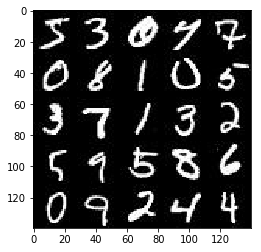

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

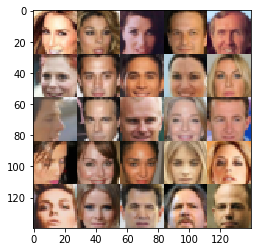

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input =  tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    z_input = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return (real_input,z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        #14*14*64
        c1 = tf.layers.conv2d(images,64,kernel_size=5,strides=2,padding='same')
        lrel1 = tf.maximum(alpha*c1, c1)
        
        #7*7*128
        c2 = tf.layers.conv2d(lrel1,128,kernel_size=5,strides=2,padding='same')
        bn1 = tf.layers.batch_normalization(c2,training=True)
        lrel2 = tf.maximum(alpha*bn1,bn1)
        
        #4*4*256
        c3 = tf.layers.conv2d(lrel2,256,kernel_size=5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(c3,training=True)
        lrel3 = tf.maximum(alpha*bn2,bn2)
        #flattening 
        flat = tf.reshape(lrel3,[-1,4*4*256])
        
        #output
        logits = tf.layers.dense(flat,1)
        out = tf.nn.sigmoid(logits)
    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        fc1 = tf.layers.dense(z,7*7*1024)
        
        #7*7*1024
        c1 = tf.reshape(fc1,[-1,7,7,1024])
        bn1 = tf.layers.batch_normalization(c1,training=is_train)
        lrel1 = tf.maximum(alpha*bn1 , bn1)
        
        #7*7*512
        c2 = tf.layers.conv2d_transpose(lrel1,512,kernel_size=5,strides=1,padding='same')
        bn2 = tf.layers.batch_normalization(c2,training=is_train)
        lrel2 = tf.maximum(alpha*bn2, bn2)
        kp1 = tf.nn.dropout(lrel2,keep_prob=keep_prob)
        
        #14*14*256
        c3 = tf.layers.conv2d_transpose(kp1,256,kernel_size=5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(c3,training=is_train)
        lrel3 = tf.maximum(alpha*bn3,bn3)
        kp2 = tf.nn.dropout(lrel3,keep_prob=keep_prob)
        
        #14*14*128
        c4 = tf.layers.conv2d_transpose(kp2,128,kernel_size=5,strides=1,padding='same')
        bn4 = tf.layers.batch_normalization(c4,training=is_train)
        lrel4 = tf.maximum(alpha*bn4,bn4)
        kp3 = tf.nn.dropout(lrel4,keep_prob=keep_prob)
        
        #28*28*64
        c5 = tf.layers.conv2d_transpose(kp3,64,kernel_size=5,strides=2,padding='same')
        bn5 = tf.layers.batch_normalization(c5,training=is_train)
        lrel5 = tf.maximum(alpha*bn5,bn5)
        kp4 = tf.nn.dropout(lrel5,keep_prob=keep_prob)
        
        #28*28*3
        c6 = tf.layers.conv2d_transpose(kp4,out_channel_dim,kernel_size=5,strides=1,padding='same')
        out = tf.nn.tanh(c6)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_model_real_logits = discriminator(input_real,reuse=False)
    d_model_fake,d_model_fake_logits = discriminator(g_model,reuse=True)
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real_logits,
                                                                         labels=tf.ones_like(d_model_real_logits) *(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                        labels=tf.zeros_like(d_model_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                   labels=tf.ones_like(d_model_fake_logits)))
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_opt,g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    
    # getting placeholders
    input_real,input_z,lr = model_inputs(image_width,image_height,image_channels,z_dim)
    
    # getting losses
    d_loss,g_loss = model_loss(input_real,input_z,image_channels)
    
    # Getting optimizers
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    step = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1,1,(batch_size,z_dim))
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                if step == 1:
                    print('initial output')
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode)
                if step % 10 == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    print('Epochs {},batches {}, dis_loss {} , gen_loss {}'.format(epoch_i+1,step,train_loss_d,train_loss_g))
                if step%100 == 0:
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode)
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


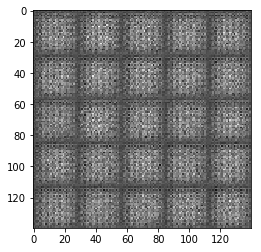

Epochs 1,batches 10, dis_loss 1.870298147201538 , gen_loss 0.38545215129852295
Epochs 1,batches 20, dis_loss 2.1712875366210938 , gen_loss 7.3456525802612305
Epochs 1,batches 30, dis_loss 3.1057307720184326 , gen_loss 0.3626830577850342
Epochs 1,batches 40, dis_loss 0.9038715362548828 , gen_loss 2.240232467651367
Epochs 1,batches 50, dis_loss 1.6412333250045776 , gen_loss 0.677293062210083
Epochs 1,batches 60, dis_loss 1.6333482265472412 , gen_loss 0.9430413246154785
Epochs 1,batches 70, dis_loss 2.566582202911377 , gen_loss 0.23300661146640778
Epochs 1,batches 80, dis_loss 1.6809043884277344 , gen_loss 0.7407678365707397
Epochs 1,batches 90, dis_loss 1.3094475269317627 , gen_loss 0.6315202116966248
Epochs 1,batches 100, dis_loss 1.4209747314453125 , gen_loss 0.8245590329170227


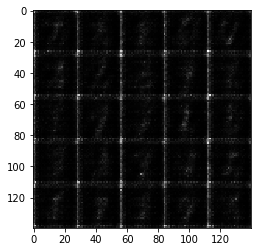

Epochs 1,batches 110, dis_loss 1.6731619834899902 , gen_loss 0.4868400990962982
Epochs 1,batches 120, dis_loss 1.891298532485962 , gen_loss 0.7503594160079956
Epochs 1,batches 130, dis_loss 1.5044548511505127 , gen_loss 0.9222800731658936
Epochs 1,batches 140, dis_loss 1.530074954032898 , gen_loss 0.6431378126144409
Epochs 1,batches 150, dis_loss 1.4340662956237793 , gen_loss 0.5782034993171692
Epochs 1,batches 160, dis_loss 1.4030723571777344 , gen_loss 0.9032447338104248
Epochs 1,batches 170, dis_loss 1.4691635370254517 , gen_loss 1.094069242477417
Epochs 1,batches 180, dis_loss 1.778083086013794 , gen_loss 0.4420289993286133
Epochs 1,batches 190, dis_loss 1.5091533660888672 , gen_loss 0.8668410778045654
Epochs 1,batches 200, dis_loss 1.6015040874481201 , gen_loss 0.40598264336586


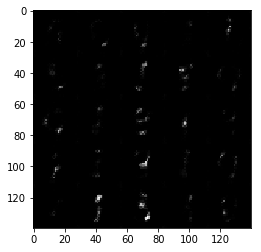

Epochs 1,batches 210, dis_loss 1.51381254196167 , gen_loss 0.5707319974899292
Epochs 1,batches 220, dis_loss 1.4272725582122803 , gen_loss 0.9465122222900391
Epochs 1,batches 230, dis_loss 1.5551984310150146 , gen_loss 0.4915864169597626
Epochs 1,batches 240, dis_loss 1.3686466217041016 , gen_loss 0.8951126933097839
Epochs 1,batches 250, dis_loss 1.6067721843719482 , gen_loss 0.42363905906677246
Epochs 1,batches 260, dis_loss 1.7978814840316772 , gen_loss 0.42057645320892334
Epochs 1,batches 270, dis_loss 1.6266508102416992 , gen_loss 0.9156414270401001
Epochs 1,batches 280, dis_loss 1.6476798057556152 , gen_loss 0.4128788411617279
Epochs 1,batches 290, dis_loss 1.542155146598816 , gen_loss 0.4976741075515747
Epochs 1,batches 300, dis_loss 1.264586091041565 , gen_loss 0.8328763842582703


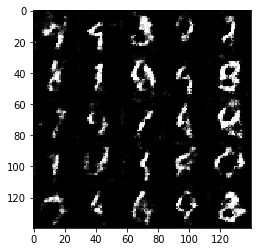

Epochs 1,batches 310, dis_loss 1.378311276435852 , gen_loss 1.0974395275115967
Epochs 1,batches 320, dis_loss 1.7719649076461792 , gen_loss 0.41479843854904175
Epochs 1,batches 330, dis_loss 1.5418795347213745 , gen_loss 0.5898752212524414
Epochs 1,batches 340, dis_loss 1.3629233837127686 , gen_loss 0.8898863792419434
Epochs 1,batches 350, dis_loss 1.595260500907898 , gen_loss 0.46913349628448486
Epochs 1,batches 360, dis_loss 1.3231146335601807 , gen_loss 1.1950830221176147
Epochs 1,batches 370, dis_loss 1.3620879650115967 , gen_loss 0.620520830154419
Epochs 1,batches 380, dis_loss 1.6617101430892944 , gen_loss 0.36457309126853943
Epochs 1,batches 390, dis_loss 1.4130007028579712 , gen_loss 0.7698222994804382
Epochs 1,batches 400, dis_loss 1.399622917175293 , gen_loss 1.003005862236023


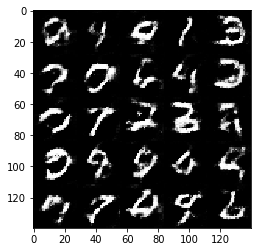

Epochs 1,batches 410, dis_loss 1.5412418842315674 , gen_loss 0.5419474840164185
Epochs 1,batches 420, dis_loss 1.5706889629364014 , gen_loss 0.48084431886672974
Epochs 1,batches 430, dis_loss 1.4532747268676758 , gen_loss 0.8022841215133667
Epochs 1,batches 440, dis_loss 1.293067455291748 , gen_loss 0.7612323760986328
Epochs 1,batches 450, dis_loss 1.4158118963241577 , gen_loss 1.1000721454620361
Epochs 1,batches 460, dis_loss 1.3367977142333984 , gen_loss 0.6727609038352966
Epochs 1,batches 470, dis_loss 1.6168501377105713 , gen_loss 0.6449499726295471
Epochs 1,batches 480, dis_loss 1.5703461170196533 , gen_loss 0.5286064147949219
Epochs 1,batches 490, dis_loss 1.3700470924377441 , gen_loss 0.672480583190918
Epochs 1,batches 500, dis_loss 1.269964337348938 , gen_loss 0.6567444205284119


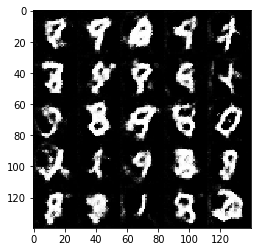

Epochs 1,batches 510, dis_loss 1.3487133979797363 , gen_loss 0.6259324550628662
Epochs 1,batches 520, dis_loss 1.5310770273208618 , gen_loss 0.49250516295433044
Epochs 1,batches 530, dis_loss 1.3982746601104736 , gen_loss 0.7340162992477417
Epochs 1,batches 540, dis_loss 1.613544225692749 , gen_loss 0.41043975949287415
Epochs 1,batches 550, dis_loss 1.3542083501815796 , gen_loss 0.7325369119644165
Epochs 1,batches 560, dis_loss 1.3890600204467773 , gen_loss 1.236993432044983
Epochs 1,batches 570, dis_loss 1.264578104019165 , gen_loss 0.778510570526123
Epochs 1,batches 580, dis_loss 1.351024866104126 , gen_loss 0.7145901918411255
Epochs 1,batches 590, dis_loss 1.2940897941589355 , gen_loss 0.9819053411483765
Epochs 1,batches 600, dis_loss 1.6126704216003418 , gen_loss 1.017075777053833


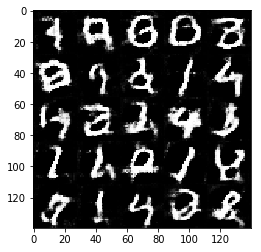

Epochs 1,batches 610, dis_loss 1.4572410583496094 , gen_loss 0.6289920806884766
Epochs 1,batches 620, dis_loss 1.3341400623321533 , gen_loss 0.6432198286056519
Epochs 1,batches 630, dis_loss 1.3526952266693115 , gen_loss 0.5850223302841187
Epochs 1,batches 640, dis_loss 1.3223326206207275 , gen_loss 0.9759606122970581
Epochs 1,batches 650, dis_loss 1.4186649322509766 , gen_loss 0.6525545120239258
Epochs 1,batches 660, dis_loss 1.4801056385040283 , gen_loss 0.5755478739738464
Epochs 1,batches 670, dis_loss 1.2903873920440674 , gen_loss 0.6932507157325745
Epochs 1,batches 680, dis_loss 1.3442630767822266 , gen_loss 0.6952708959579468
Epochs 1,batches 690, dis_loss 1.3498320579528809 , gen_loss 0.6830592751502991
Epochs 1,batches 700, dis_loss 1.6268653869628906 , gen_loss 0.4734683632850647


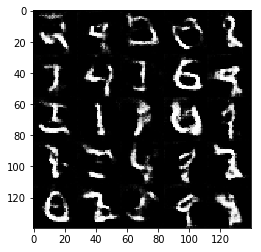

Epochs 1,batches 710, dis_loss 1.3052828311920166 , gen_loss 0.8322392702102661
Epochs 1,batches 720, dis_loss 1.4552536010742188 , gen_loss 0.6473639011383057
Epochs 1,batches 730, dis_loss 1.4177641868591309 , gen_loss 1.3168362379074097
Epochs 1,batches 740, dis_loss 1.3200513124465942 , gen_loss 0.6980016231536865
Epochs 1,batches 750, dis_loss 1.3381249904632568 , gen_loss 0.7921231389045715
Epochs 1,batches 760, dis_loss 1.3688442707061768 , gen_loss 0.698807418346405
Epochs 1,batches 770, dis_loss 1.3149105310440063 , gen_loss 0.6386476755142212
Epochs 1,batches 780, dis_loss 1.4256865978240967 , gen_loss 0.5899676084518433
Epochs 1,batches 790, dis_loss 1.2017593383789062 , gen_loss 1.3955845832824707
Epochs 1,batches 800, dis_loss 1.1100144386291504 , gen_loss 0.879562258720398


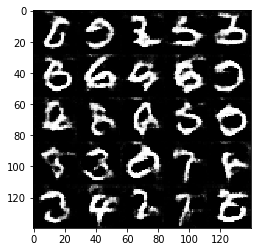

Epochs 1,batches 810, dis_loss 1.2311233282089233 , gen_loss 1.1833102703094482
Epochs 1,batches 820, dis_loss 1.3246331214904785 , gen_loss 0.9267454147338867
Epochs 1,batches 830, dis_loss 1.4416284561157227 , gen_loss 1.044907569885254
Epochs 1,batches 840, dis_loss 1.4315094947814941 , gen_loss 0.4894503355026245
Epochs 1,batches 850, dis_loss 1.4102656841278076 , gen_loss 0.5332472920417786
Epochs 1,batches 860, dis_loss 1.274967074394226 , gen_loss 0.785774290561676
Epochs 1,batches 870, dis_loss 1.339451551437378 , gen_loss 0.5691061615943909
Epochs 1,batches 880, dis_loss 1.3030962944030762 , gen_loss 0.9777401089668274
Epochs 1,batches 890, dis_loss 1.2272191047668457 , gen_loss 0.7828152179718018
Epochs 1,batches 900, dis_loss 1.316922903060913 , gen_loss 0.7177718877792358


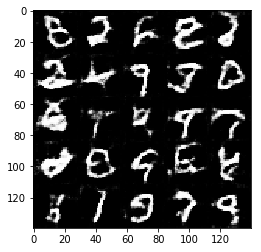

Epochs 1,batches 910, dis_loss 1.369419813156128 , gen_loss 0.8125824928283691
Epochs 1,batches 920, dis_loss 1.283051609992981 , gen_loss 0.7789344787597656
Epochs 1,batches 930, dis_loss 1.283708095550537 , gen_loss 0.7680255770683289
Epochs 1,batches 940, dis_loss 1.3681443929672241 , gen_loss 1.2427884340286255
Epochs 1,batches 950, dis_loss 1.2353382110595703 , gen_loss 1.1462724208831787
Epochs 1,batches 960, dis_loss 1.7013583183288574 , gen_loss 0.44079485535621643
Epochs 1,batches 970, dis_loss 1.167236566543579 , gen_loss 0.9503359198570251
Epochs 1,batches 980, dis_loss 1.3987748622894287 , gen_loss 0.5426424145698547
Epochs 1,batches 990, dis_loss 1.1056206226348877 , gen_loss 0.9282572865486145
Epochs 1,batches 1000, dis_loss 1.2928612232208252 , gen_loss 0.7789498567581177


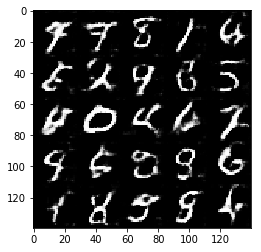

Epochs 1,batches 1010, dis_loss 1.2759780883789062 , gen_loss 0.7365740537643433
Epochs 1,batches 1020, dis_loss 1.3878862857818604 , gen_loss 0.5808348059654236
Epochs 1,batches 1030, dis_loss 1.7592732906341553 , gen_loss 0.3101543188095093
Epochs 1,batches 1040, dis_loss 1.2153983116149902 , gen_loss 0.771584153175354
Epochs 1,batches 1050, dis_loss 1.2299234867095947 , gen_loss 1.066322922706604
Epochs 1,batches 1060, dis_loss 1.2005070447921753 , gen_loss 0.8567204475402832
Epochs 1,batches 1070, dis_loss 1.396591067314148 , gen_loss 1.4181956052780151
Epochs 1,batches 1080, dis_loss 1.356813907623291 , gen_loss 0.7341322898864746
Epochs 1,batches 1090, dis_loss 1.391921877861023 , gen_loss 0.8632493615150452
Epochs 1,batches 1100, dis_loss 1.3554959297180176 , gen_loss 0.5550433397293091


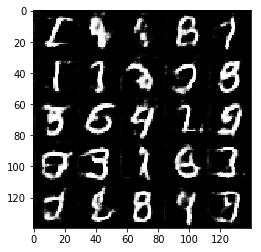

Epochs 1,batches 1110, dis_loss 1.5277994871139526 , gen_loss 0.4476020038127899
Epochs 1,batches 1120, dis_loss 1.3296518325805664 , gen_loss 0.8528565168380737
Epochs 1,batches 1130, dis_loss 1.3019636869430542 , gen_loss 0.6833662986755371
Epochs 1,batches 1140, dis_loss 1.2814122438430786 , gen_loss 0.8903478384017944
Epochs 1,batches 1150, dis_loss 1.3748180866241455 , gen_loss 0.5239402651786804
Epochs 1,batches 1160, dis_loss 1.1361184120178223 , gen_loss 0.9539855122566223
Epochs 1,batches 1170, dis_loss 1.3744276762008667 , gen_loss 0.9988417625427246
Epochs 1,batches 1180, dis_loss 1.302441120147705 , gen_loss 0.654532790184021
Epochs 1,batches 1190, dis_loss 1.217306137084961 , gen_loss 0.7699663639068604
Epochs 1,batches 1200, dis_loss 1.1837244033813477 , gen_loss 1.2664918899536133


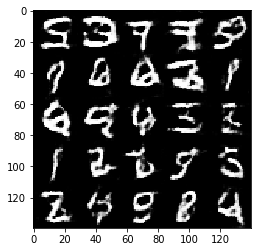

Epochs 1,batches 1210, dis_loss 1.0182479619979858 , gen_loss 1.0395145416259766
Epochs 1,batches 1220, dis_loss 1.3644535541534424 , gen_loss 0.5858193635940552
Epochs 1,batches 1230, dis_loss 1.038423776626587 , gen_loss 0.9744916558265686
Epochs 1,batches 1240, dis_loss 1.2126085758209229 , gen_loss 0.7128417491912842
Epochs 1,batches 1250, dis_loss 1.3673667907714844 , gen_loss 0.8857423067092896
Epochs 1,batches 1260, dis_loss 1.3743371963500977 , gen_loss 0.5573561787605286
Epochs 1,batches 1270, dis_loss 1.2314858436584473 , gen_loss 1.3893412351608276
Epochs 1,batches 1280, dis_loss 1.3482328653335571 , gen_loss 0.5615941286087036
Epochs 1,batches 1290, dis_loss 1.1194872856140137 , gen_loss 1.0052669048309326
Epochs 1,batches 1300, dis_loss 1.3399417400360107 , gen_loss 0.7535580396652222


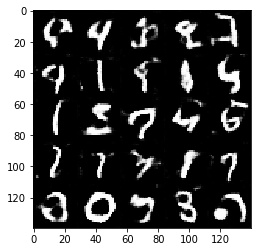

Epochs 1,batches 1310, dis_loss 1.075324535369873 , gen_loss 1.0866914987564087
Epochs 1,batches 1320, dis_loss 1.4021685123443604 , gen_loss 0.5095433592796326
Epochs 1,batches 1330, dis_loss 1.3559707403182983 , gen_loss 1.262374758720398
Epochs 1,batches 1340, dis_loss 1.6262152194976807 , gen_loss 0.3932421803474426
Epochs 1,batches 1350, dis_loss 1.4194512367248535 , gen_loss 0.5152183175086975
Epochs 1,batches 1360, dis_loss 1.296273946762085 , gen_loss 0.7621792554855347
Epochs 1,batches 1370, dis_loss 1.3577067852020264 , gen_loss 0.5792173147201538
Epochs 1,batches 1380, dis_loss 1.5147931575775146 , gen_loss 0.49078255891799927
Epochs 1,batches 1390, dis_loss 1.135127305984497 , gen_loss 1.0704405307769775
Epochs 1,batches 1400, dis_loss 1.3952312469482422 , gen_loss 0.5050995349884033


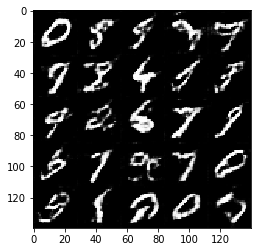

Epochs 1,batches 1410, dis_loss 1.0930049419403076 , gen_loss 1.0557670593261719
Epochs 1,batches 1420, dis_loss 1.694710373878479 , gen_loss 0.36397600173950195
Epochs 1,batches 1430, dis_loss 1.2910046577453613 , gen_loss 0.6240324974060059
Epochs 1,batches 1440, dis_loss 1.3781529664993286 , gen_loss 0.5225478410720825
Epochs 1,batches 1450, dis_loss 1.4520680904388428 , gen_loss 0.5281845927238464
Epochs 1,batches 1460, dis_loss 1.1664698123931885 , gen_loss 0.7664288282394409
Epochs 1,batches 1470, dis_loss 1.210951328277588 , gen_loss 1.1199743747711182
Epochs 1,batches 1480, dis_loss 1.3730294704437256 , gen_loss 0.5757912397384644
Epochs 1,batches 1490, dis_loss 1.2718892097473145 , gen_loss 0.6726094484329224
Epochs 1,batches 1500, dis_loss 1.453574776649475 , gen_loss 0.5277212858200073


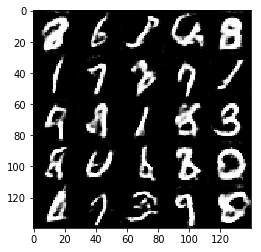

Epochs 1,batches 1510, dis_loss 1.3811930418014526 , gen_loss 0.49848753213882446
Epochs 1,batches 1520, dis_loss 1.1980795860290527 , gen_loss 0.6479815244674683
Epochs 1,batches 1530, dis_loss 1.3660941123962402 , gen_loss 0.6677893400192261
Epochs 1,batches 1540, dis_loss 1.2745020389556885 , gen_loss 0.8989647030830383
Epochs 1,batches 1550, dis_loss 1.2523820400238037 , gen_loss 0.8207036256790161
Epochs 1,batches 1560, dis_loss 1.2986998558044434 , gen_loss 0.5677348375320435
Epochs 1,batches 1570, dis_loss 1.1800227165222168 , gen_loss 0.7428122758865356
Epochs 1,batches 1580, dis_loss 1.3330700397491455 , gen_loss 0.5480793118476868
Epochs 1,batches 1590, dis_loss 1.1753742694854736 , gen_loss 0.9536916613578796
Epochs 1,batches 1600, dis_loss 1.5164237022399902 , gen_loss 1.9246679544448853


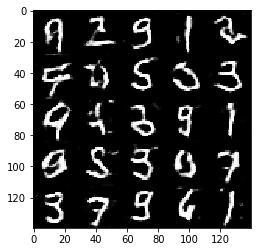

Epochs 1,batches 1610, dis_loss 1.1506969928741455 , gen_loss 0.7474923133850098
Epochs 1,batches 1620, dis_loss 1.133886694908142 , gen_loss 0.9159011244773865
Epochs 1,batches 1630, dis_loss 1.1740185022354126 , gen_loss 0.9036463499069214
Epochs 1,batches 1640, dis_loss 1.2357879877090454 , gen_loss 0.7238906621932983
Epochs 1,batches 1650, dis_loss 1.1890298128128052 , gen_loss 0.8186302185058594
Epochs 1,batches 1660, dis_loss 1.0750744342803955 , gen_loss 1.0518317222595215
Epochs 1,batches 1670, dis_loss 1.082782506942749 , gen_loss 0.916365385055542
Epochs 1,batches 1680, dis_loss 1.2821896076202393 , gen_loss 0.6421961188316345
Epochs 1,batches 1690, dis_loss 1.2214789390563965 , gen_loss 0.6713114380836487
Epochs 1,batches 1700, dis_loss 0.9999093413352966 , gen_loss 1.0895426273345947


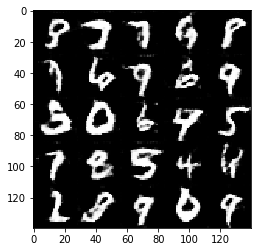

Epochs 1,batches 1710, dis_loss 1.5158429145812988 , gen_loss 0.4786587357521057
Epochs 1,batches 1720, dis_loss 1.2597711086273193 , gen_loss 0.7469408512115479
Epochs 1,batches 1730, dis_loss 1.440565586090088 , gen_loss 0.49516844749450684
Epochs 1,batches 1740, dis_loss 1.1056020259857178 , gen_loss 1.0985090732574463
Epochs 1,batches 1750, dis_loss 1.1519237756729126 , gen_loss 0.7984702587127686
Epochs 1,batches 1760, dis_loss 1.4035245180130005 , gen_loss 0.5905367732048035
Epochs 1,batches 1770, dis_loss 1.0489429235458374 , gen_loss 0.9433083534240723
Epochs 1,batches 1780, dis_loss 1.359727382659912 , gen_loss 0.5240114331245422
Epochs 1,batches 1790, dis_loss 1.1710106134414673 , gen_loss 0.9007951617240906
Epochs 1,batches 1800, dis_loss 1.0043175220489502 , gen_loss 0.8875142335891724


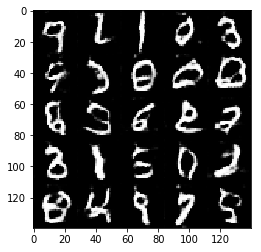

Epochs 1,batches 1810, dis_loss 1.78975248336792 , gen_loss 0.33907732367515564
Epochs 1,batches 1820, dis_loss 1.3142547607421875 , gen_loss 0.616559624671936
Epochs 1,batches 1830, dis_loss 1.253814697265625 , gen_loss 0.7614755630493164
Epochs 1,batches 1840, dis_loss 1.1320085525512695 , gen_loss 0.9570452570915222
Epochs 1,batches 1850, dis_loss 1.1148366928100586 , gen_loss 0.7846580743789673
Epochs 1,batches 1860, dis_loss 1.2050869464874268 , gen_loss 0.9284958243370056
Epochs 1,batches 1870, dis_loss 0.9881797432899475 , gen_loss 1.1363131999969482
Epochs 1,batches 1880, dis_loss 1.3894751071929932 , gen_loss 0.5364274978637695
Epochs 1,batches 1890, dis_loss 1.2658480405807495 , gen_loss 0.7067854404449463
Epochs 1,batches 1900, dis_loss 1.3269503116607666 , gen_loss 1.539757490158081


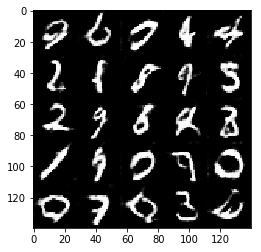

Epochs 1,batches 1910, dis_loss 1.0785062313079834 , gen_loss 0.845916748046875
Epochs 1,batches 1920, dis_loss 1.7031410932540894 , gen_loss 0.30182257294654846
Epochs 1,batches 1930, dis_loss 1.2363307476043701 , gen_loss 0.7733352780342102
Epochs 1,batches 1940, dis_loss 1.2646708488464355 , gen_loss 0.7065328359603882
Epochs 1,batches 1950, dis_loss 1.1772851943969727 , gen_loss 0.6897844076156616
Epochs 1,batches 1960, dis_loss 1.0667719841003418 , gen_loss 0.8281657099723816
Epochs 1,batches 1970, dis_loss 0.9809800982475281 , gen_loss 1.0722124576568604
Epochs 1,batches 1980, dis_loss 1.0611604452133179 , gen_loss 0.9050490260124207
Epochs 1,batches 1990, dis_loss 1.0230495929718018 , gen_loss 0.9240400791168213
Epochs 1,batches 2000, dis_loss 1.3461253643035889 , gen_loss 0.6648094058036804


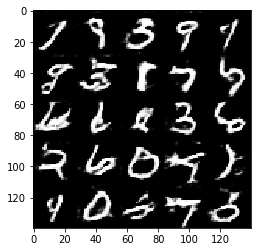

Epochs 1,batches 2010, dis_loss 1.0548641681671143 , gen_loss 0.8384688496589661
Epochs 1,batches 2020, dis_loss 1.5407779216766357 , gen_loss 1.6771228313446045
Epochs 1,batches 2030, dis_loss 1.2664570808410645 , gen_loss 0.9534956812858582
Epochs 1,batches 2040, dis_loss 1.1258691549301147 , gen_loss 0.8511101007461548
Epochs 1,batches 2050, dis_loss 1.253118872642517 , gen_loss 1.09730863571167
Epochs 1,batches 2060, dis_loss 1.2168805599212646 , gen_loss 0.6554149389266968
Epochs 1,batches 2070, dis_loss 1.3501412868499756 , gen_loss 0.5343620777130127
Epochs 1,batches 2080, dis_loss 1.4540363550186157 , gen_loss 0.4975099265575409
Epochs 1,batches 2090, dis_loss 1.2486462593078613 , gen_loss 0.6496081352233887
Epochs 1,batches 2100, dis_loss 1.043938398361206 , gen_loss 0.9087586998939514


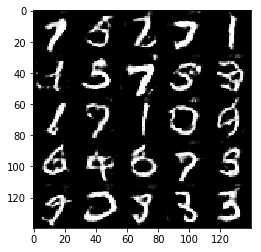

Epochs 1,batches 2110, dis_loss 1.0095134973526 , gen_loss 0.8313360214233398
Epochs 1,batches 2120, dis_loss 0.9940908551216125 , gen_loss 1.1548771858215332
Epochs 1,batches 2130, dis_loss 1.1247375011444092 , gen_loss 0.6107525825500488
Epochs 1,batches 2140, dis_loss 1.4524707794189453 , gen_loss 0.49430179595947266
Epochs 1,batches 2150, dis_loss 0.9157311916351318 , gen_loss 1.3001903295516968
Epochs 1,batches 2160, dis_loss 1.625089168548584 , gen_loss 0.4925726652145386
Epochs 1,batches 2170, dis_loss 1.1398922204971313 , gen_loss 1.6012804508209229
Epochs 1,batches 2180, dis_loss 0.8946864604949951 , gen_loss 1.1044762134552002
Epochs 1,batches 2190, dis_loss 0.8934082984924316 , gen_loss 1.239999532699585
Epochs 1,batches 2200, dis_loss 1.1515889167785645 , gen_loss 0.6700586080551147


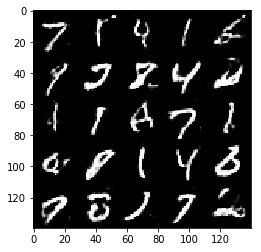

Epochs 1,batches 2210, dis_loss 1.041216254234314 , gen_loss 0.8333226442337036
Epochs 1,batches 2220, dis_loss 1.5758543014526367 , gen_loss 0.3879302740097046
Epochs 1,batches 2230, dis_loss 1.212316870689392 , gen_loss 0.663430392742157
Epochs 1,batches 2240, dis_loss 1.026136875152588 , gen_loss 0.7627537250518799
Epochs 1,batches 2250, dis_loss 1.289954423904419 , gen_loss 0.681612491607666
Epochs 1,batches 2260, dis_loss 1.149006962776184 , gen_loss 0.7641819715499878
Epochs 1,batches 2270, dis_loss 1.4855170249938965 , gen_loss 0.4466482102870941
Epochs 1,batches 2280, dis_loss 1.033035397529602 , gen_loss 1.0825543403625488
Epochs 1,batches 2290, dis_loss 1.2272597551345825 , gen_loss 0.6780604124069214
Epochs 1,batches 2300, dis_loss 1.1113011837005615 , gen_loss 0.8183550834655762


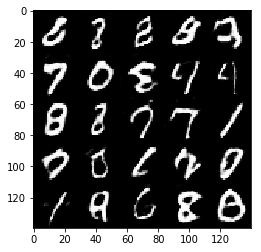

Epochs 1,batches 2310, dis_loss 1.2973660230636597 , gen_loss 0.5743806958198547
Epochs 1,batches 2320, dis_loss 0.966412365436554 , gen_loss 1.5335438251495361
Epochs 1,batches 2330, dis_loss 1.1700925827026367 , gen_loss 0.8104212284088135
Epochs 1,batches 2340, dis_loss 1.1212890148162842 , gen_loss 1.0173895359039307
Epochs 1,batches 2350, dis_loss 1.0833925008773804 , gen_loss 0.9687567949295044
Epochs 1,batches 2360, dis_loss 1.152437448501587 , gen_loss 0.690048098564148
Epochs 1,batches 2370, dis_loss 1.1445274353027344 , gen_loss 0.7137141227722168
Epochs 1,batches 2380, dis_loss 1.557999849319458 , gen_loss 0.4461734890937805
Epochs 1,batches 2390, dis_loss 0.9513550996780396 , gen_loss 1.0114870071411133
Epochs 1,batches 2400, dis_loss 0.7917680740356445 , gen_loss 1.3857169151306152


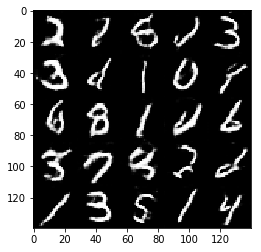

Epochs 1,batches 2410, dis_loss 0.8516588807106018 , gen_loss 1.0640039443969727
Epochs 1,batches 2420, dis_loss 0.8719433546066284 , gen_loss 1.2610118389129639
Epochs 1,batches 2430, dis_loss 1.7559282779693604 , gen_loss 1.1621029376983643
Epochs 1,batches 2440, dis_loss 1.1650726795196533 , gen_loss 0.7039475440979004
Epochs 1,batches 2450, dis_loss 1.1562572717666626 , gen_loss 1.2324274778366089
Epochs 1,batches 2460, dis_loss 1.7219059467315674 , gen_loss 0.3303810954093933
Epochs 1,batches 2470, dis_loss 1.1040351390838623 , gen_loss 0.9698872566223145
Epochs 1,batches 2480, dis_loss 1.022374153137207 , gen_loss 1.4789788722991943
Epochs 1,batches 2490, dis_loss 1.1839184761047363 , gen_loss 1.2411720752716064
Epochs 1,batches 2500, dis_loss 0.8683744668960571 , gen_loss 1.052225112915039


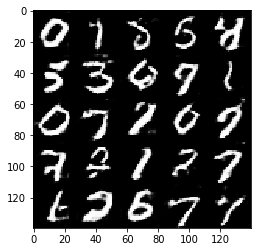

Epochs 1,batches 2510, dis_loss 1.1876599788665771 , gen_loss 1.0387680530548096
Epochs 1,batches 2520, dis_loss 1.395591378211975 , gen_loss 0.484109103679657
Epochs 1,batches 2530, dis_loss 0.9739850759506226 , gen_loss 0.9296475648880005
Epochs 1,batches 2540, dis_loss 1.1484558582305908 , gen_loss 0.8183044195175171
Epochs 1,batches 2550, dis_loss 0.9933463335037231 , gen_loss 1.4038034677505493
Epochs 1,batches 2560, dis_loss 0.8296845555305481 , gen_loss 1.138383150100708
Epochs 1,batches 2570, dis_loss 1.0257668495178223 , gen_loss 1.2324851751327515
Epochs 1,batches 2580, dis_loss 1.1537017822265625 , gen_loss 0.8127301931381226
Epochs 1,batches 2590, dis_loss 0.9546786546707153 , gen_loss 1.8321564197540283
Epochs 1,batches 2600, dis_loss 1.1897637844085693 , gen_loss 1.2116155624389648


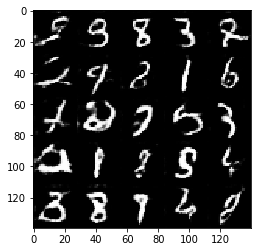

Epochs 1,batches 2610, dis_loss 0.954688310623169 , gen_loss 1.25723397731781
Epochs 1,batches 2620, dis_loss 1.022143840789795 , gen_loss 0.9022074341773987
Epochs 1,batches 2630, dis_loss 0.9530922174453735 , gen_loss 0.8647807836532593
Epochs 1,batches 2640, dis_loss 1.052944540977478 , gen_loss 0.9791977405548096
Epochs 1,batches 2650, dis_loss 0.8701158761978149 , gen_loss 1.552609920501709
Epochs 1,batches 2660, dis_loss 1.1021833419799805 , gen_loss 0.7398837804794312
Epochs 1,batches 2670, dis_loss 1.3780680894851685 , gen_loss 0.5874063968658447
Epochs 1,batches 2680, dis_loss 1.0862644910812378 , gen_loss 0.8237358331680298
Epochs 1,batches 2690, dis_loss 1.0287909507751465 , gen_loss 1.205984115600586
Epochs 1,batches 2700, dis_loss 1.2128890752792358 , gen_loss 0.706632673740387


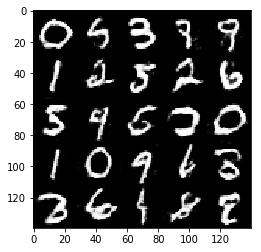

Epochs 1,batches 2710, dis_loss 1.0717178583145142 , gen_loss 1.4607913494110107
Epochs 1,batches 2720, dis_loss 1.4796196222305298 , gen_loss 0.499743789434433
Epochs 1,batches 2730, dis_loss 0.7930389046669006 , gen_loss 1.3294427394866943
Epochs 1,batches 2740, dis_loss 1.2770706415176392 , gen_loss 0.8461729288101196
Epochs 1,batches 2750, dis_loss 1.2340898513793945 , gen_loss 0.672547459602356
Epochs 1,batches 2760, dis_loss 0.9690642356872559 , gen_loss 0.9063405394554138
Epochs 1,batches 2770, dis_loss 1.0197926759719849 , gen_loss 0.890473484992981
Epochs 1,batches 2780, dis_loss 0.9717006683349609 , gen_loss 1.0017917156219482
Epochs 1,batches 2790, dis_loss 1.0721594095230103 , gen_loss 0.7673240303993225
Epochs 1,batches 2800, dis_loss 1.3380515575408936 , gen_loss 0.5661171078681946


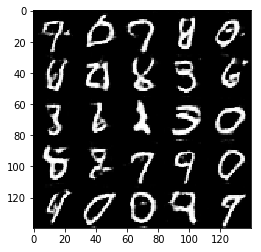

Epochs 1,batches 2810, dis_loss 0.9719807505607605 , gen_loss 0.889282763004303
Epochs 1,batches 2820, dis_loss 0.9587920904159546 , gen_loss 1.0747053623199463
Epochs 1,batches 2830, dis_loss 1.1534229516983032 , gen_loss 0.6655574440956116
Epochs 1,batches 2840, dis_loss 1.2193580865859985 , gen_loss 0.8942723274230957
Epochs 1,batches 2850, dis_loss 1.164856195449829 , gen_loss 0.6586878299713135
Epochs 1,batches 2860, dis_loss 0.9398893117904663 , gen_loss 1.2097141742706299
Epochs 1,batches 2870, dis_loss 1.713326096534729 , gen_loss 0.3252451717853546
Epochs 1,batches 2880, dis_loss 1.356975793838501 , gen_loss 0.5510008931159973
Epochs 1,batches 2890, dis_loss 0.8589452505111694 , gen_loss 1.8111398220062256
Epochs 1,batches 2900, dis_loss 0.9760092496871948 , gen_loss 1.5422972440719604


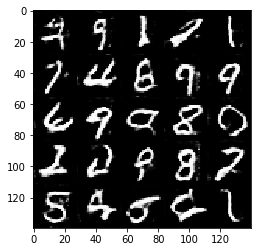

Epochs 1,batches 2910, dis_loss 1.0743552446365356 , gen_loss 0.7423866391181946
Epochs 1,batches 2920, dis_loss 0.9237176179885864 , gen_loss 0.9374483823776245
Epochs 1,batches 2930, dis_loss 1.0592998266220093 , gen_loss 0.8305896520614624
Epochs 1,batches 2940, dis_loss 1.2056663036346436 , gen_loss 0.7720670104026794
Epochs 1,batches 2950, dis_loss 0.9062192440032959 , gen_loss 1.0900262594223022
Epochs 1,batches 2960, dis_loss 0.8465462923049927 , gen_loss 1.1413004398345947
Epochs 1,batches 2970, dis_loss 0.7365435361862183 , gen_loss 1.526963233947754
Epochs 1,batches 2980, dis_loss 1.085923433303833 , gen_loss 1.0024569034576416
Epochs 1,batches 2990, dis_loss 1.618996262550354 , gen_loss 0.42105919122695923
Epochs 1,batches 3000, dis_loss 1.3466050624847412 , gen_loss 0.6536591053009033


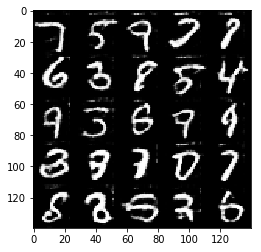

Epochs 1,batches 3010, dis_loss 0.7635484337806702 , gen_loss 1.7644972801208496
Epochs 1,batches 3020, dis_loss 1.1617743968963623 , gen_loss 0.6864916682243347
Epochs 1,batches 3030, dis_loss 0.7888277769088745 , gen_loss 1.4277745485305786
Epochs 1,batches 3040, dis_loss 0.9561806917190552 , gen_loss 0.9843046069145203
Epochs 1,batches 3050, dis_loss 1.6184766292572021 , gen_loss 0.3796422481536865
Epochs 1,batches 3060, dis_loss 1.3034708499908447 , gen_loss 2.733952522277832
Epochs 1,batches 3070, dis_loss 0.7996011972427368 , gen_loss 1.6265008449554443
Epochs 1,batches 3080, dis_loss 0.7600992918014526 , gen_loss 1.3266570568084717
Epochs 1,batches 3090, dis_loss 1.140684723854065 , gen_loss 0.9839568734169006
Epochs 1,batches 3100, dis_loss 1.4085705280303955 , gen_loss 0.5893213748931885


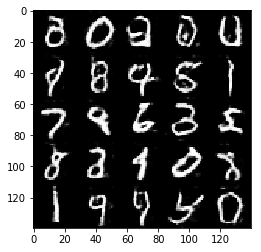

Epochs 1,batches 3110, dis_loss 0.899251401424408 , gen_loss 1.061147689819336
Epochs 1,batches 3120, dis_loss 0.8892792463302612 , gen_loss 1.2385449409484863
Epochs 1,batches 3130, dis_loss 0.8492718935012817 , gen_loss 1.0739939212799072
Epochs 1,batches 3140, dis_loss 1.1866108179092407 , gen_loss 0.7316147089004517
Epochs 1,batches 3150, dis_loss 1.3535971641540527 , gen_loss 1.1862961053848267
Epochs 1,batches 3160, dis_loss 1.0424880981445312 , gen_loss 1.8136701583862305
Epochs 1,batches 3170, dis_loss 1.0794384479522705 , gen_loss 1.0012226104736328
Epochs 1,batches 3180, dis_loss 1.157479166984558 , gen_loss 0.7698808908462524
Epochs 1,batches 3190, dis_loss 0.872640073299408 , gen_loss 1.0330363512039185
Epochs 1,batches 3200, dis_loss 1.0644381046295166 , gen_loss 0.9212244749069214


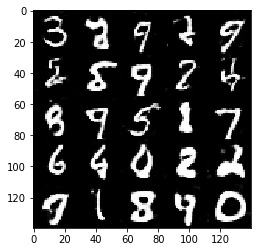

Epochs 1,batches 3210, dis_loss 1.278038740158081 , gen_loss 0.6301961541175842
Epochs 1,batches 3220, dis_loss 0.836492657661438 , gen_loss 1.1017427444458008
Epochs 1,batches 3230, dis_loss 1.187976598739624 , gen_loss 0.6027886867523193
Epochs 1,batches 3240, dis_loss 1.2220743894577026 , gen_loss 1.7331830263137817
Epochs 1,batches 3250, dis_loss 0.9295001029968262 , gen_loss 0.8209323883056641
Epochs 1,batches 3260, dis_loss 1.0198255777359009 , gen_loss 1.0183215141296387
Epochs 1,batches 3270, dis_loss 0.8562972545623779 , gen_loss 2.3912734985351562
Epochs 1,batches 3280, dis_loss 0.8353138566017151 , gen_loss 1.3081181049346924
Epochs 1,batches 3290, dis_loss 0.8961116075515747 , gen_loss 1.483577847480774
Epochs 1,batches 3300, dis_loss 0.8777641654014587 , gen_loss 0.9985349178314209


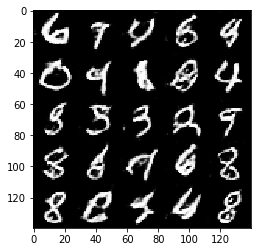

Epochs 1,batches 3310, dis_loss 1.1458423137664795 , gen_loss 1.854075312614441
Epochs 1,batches 3320, dis_loss 0.9916539192199707 , gen_loss 0.8221389651298523
Epochs 1,batches 3330, dis_loss 0.7657322883605957 , gen_loss 1.3163648843765259
Epochs 1,batches 3340, dis_loss 1.07954740524292 , gen_loss 1.3219044208526611
Epochs 1,batches 3350, dis_loss 1.4973361492156982 , gen_loss 0.5172624588012695
Epochs 1,batches 3360, dis_loss 0.7393296957015991 , gen_loss 1.340092420578003
Epochs 1,batches 3370, dis_loss 0.8261368870735168 , gen_loss 1.3818864822387695
Epochs 1,batches 3380, dis_loss 0.9617725610733032 , gen_loss 1.1555280685424805
Epochs 1,batches 3390, dis_loss 0.9478449821472168 , gen_loss 1.8828215599060059
Epochs 1,batches 3400, dis_loss 0.7632721066474915 , gen_loss 1.208884358406067


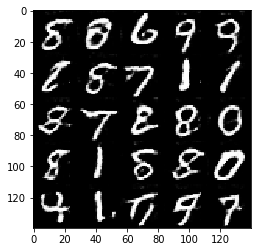

Epochs 1,batches 3410, dis_loss 0.8635963201522827 , gen_loss 1.6373448371887207
Epochs 1,batches 3420, dis_loss 0.7265844941139221 , gen_loss 1.5427970886230469
Epochs 1,batches 3430, dis_loss 0.8565006852149963 , gen_loss 1.5122123956680298
Epochs 1,batches 3440, dis_loss 0.6378116011619568 , gen_loss 1.8467258214950562
Epochs 1,batches 3450, dis_loss 1.2747994661331177 , gen_loss 0.781083345413208
Epochs 1,batches 3460, dis_loss 1.2147835493087769 , gen_loss 1.3429210186004639
Epochs 1,batches 3470, dis_loss 0.6711177825927734 , gen_loss 2.005375385284424
Epochs 1,batches 3480, dis_loss 0.9416213035583496 , gen_loss 0.9695383310317993
Epochs 1,batches 3490, dis_loss 1.2853896617889404 , gen_loss 0.5482813119888306
Epochs 1,batches 3500, dis_loss 0.9693467020988464 , gen_loss 0.853626012802124


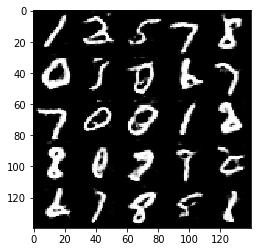

Epochs 1,batches 3510, dis_loss 0.996903121471405 , gen_loss 1.2626824378967285
Epochs 1,batches 3520, dis_loss 1.178986668586731 , gen_loss 0.5997080206871033
Epochs 1,batches 3530, dis_loss 1.266693353652954 , gen_loss 0.9241286516189575
Epochs 1,batches 3540, dis_loss 1.049605131149292 , gen_loss 0.8701162338256836
Epochs 1,batches 3550, dis_loss 0.8629505634307861 , gen_loss 0.9552226066589355
Epochs 1,batches 3560, dis_loss 0.820488452911377 , gen_loss 1.1872830390930176
Epochs 1,batches 3570, dis_loss 1.0949516296386719 , gen_loss 0.8930107355117798
Epochs 1,batches 3580, dis_loss 1.2443634271621704 , gen_loss 0.7476270198822021
Epochs 1,batches 3590, dis_loss 1.0382373332977295 , gen_loss 1.221521258354187
Epochs 1,batches 3600, dis_loss 0.9429710507392883 , gen_loss 0.9993734955787659


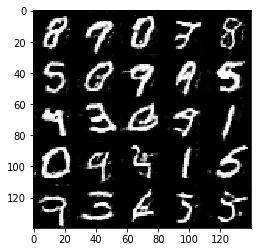

Epochs 1,batches 3610, dis_loss 1.356432318687439 , gen_loss 0.5854594707489014
Epochs 1,batches 3620, dis_loss 0.7652460336685181 , gen_loss 1.5703753232955933
Epochs 1,batches 3630, dis_loss 1.9208991527557373 , gen_loss 0.4087432622909546
Epochs 1,batches 3640, dis_loss 1.0109584331512451 , gen_loss 1.2944636344909668
Epochs 1,batches 3650, dis_loss 0.9573459625244141 , gen_loss 1.8038477897644043
Epochs 1,batches 3660, dis_loss 1.2822182178497314 , gen_loss 0.5876714587211609
Epochs 1,batches 3670, dis_loss 0.9092596769332886 , gen_loss 1.0339515209197998
Epochs 1,batches 3680, dis_loss 1.2148898839950562 , gen_loss 0.577445387840271
Epochs 1,batches 3690, dis_loss 1.5814460515975952 , gen_loss 0.3442862331867218
Epochs 1,batches 3700, dis_loss 0.9905160665512085 , gen_loss 0.765113353729248


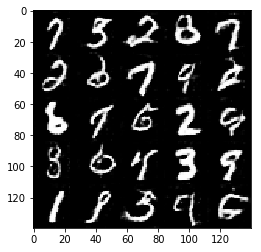

Epochs 1,batches 3710, dis_loss 0.7293977737426758 , gen_loss 1.2705250978469849
Epochs 1,batches 3720, dis_loss 0.8902541399002075 , gen_loss 1.2969944477081299
Epochs 1,batches 3730, dis_loss 0.9751985669136047 , gen_loss 2.052142858505249
Epochs 1,batches 3740, dis_loss 1.2014899253845215 , gen_loss 0.6759086847305298
Epochs 1,batches 3750, dis_loss 0.9418423771858215 , gen_loss 1.1195663213729858
Epochs 2,batches 3760, dis_loss 0.7576023936271667 , gen_loss 1.4520783424377441
Epochs 2,batches 3770, dis_loss 0.9965571165084839 , gen_loss 0.9170607924461365
Epochs 2,batches 3780, dis_loss 1.1344799995422363 , gen_loss 0.7813230752944946
Epochs 2,batches 3790, dis_loss 1.0314204692840576 , gen_loss 0.7619991302490234
Epochs 2,batches 3800, dis_loss 1.060596227645874 , gen_loss 0.7211878299713135


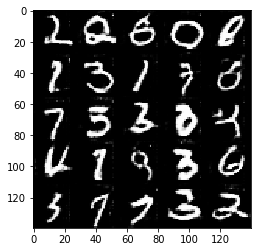

Epochs 2,batches 3810, dis_loss 1.141316533088684 , gen_loss 0.7344757914543152
Epochs 2,batches 3820, dis_loss 0.8901369571685791 , gen_loss 1.1549656391143799
Epochs 2,batches 3830, dis_loss 0.8033829927444458 , gen_loss 1.8866031169891357
Epochs 2,batches 3840, dis_loss 1.1665483713150024 , gen_loss 0.5810315608978271
Epochs 2,batches 3850, dis_loss 1.0552842617034912 , gen_loss 0.8173447251319885
Epochs 2,batches 3860, dis_loss 1.1472355127334595 , gen_loss 1.8426413536071777
Epochs 2,batches 3870, dis_loss 1.045365571975708 , gen_loss 0.9863247871398926
Epochs 2,batches 3880, dis_loss 0.897220253944397 , gen_loss 1.0177066326141357
Epochs 2,batches 3890, dis_loss 0.9832857847213745 , gen_loss 1.037322759628296
Epochs 2,batches 3900, dis_loss 0.8129642605781555 , gen_loss 1.3153951168060303


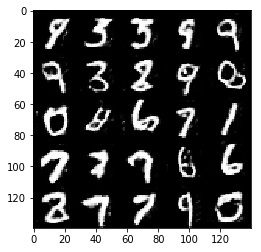

Epochs 2,batches 3910, dis_loss 0.969579815864563 , gen_loss 1.2865331172943115
Epochs 2,batches 3920, dis_loss 1.1212875843048096 , gen_loss 0.9311577677726746
Epochs 2,batches 3930, dis_loss 0.8286012411117554 , gen_loss 1.2347893714904785
Epochs 2,batches 3940, dis_loss 1.2862987518310547 , gen_loss 0.5510051250457764
Epochs 2,batches 3950, dis_loss 0.9549938440322876 , gen_loss 1.0709437131881714
Epochs 2,batches 3960, dis_loss 0.8217085003852844 , gen_loss 1.403653621673584
Epochs 2,batches 3970, dis_loss 1.1509875059127808 , gen_loss 1.7510504722595215
Epochs 2,batches 3980, dis_loss 1.0795692205429077 , gen_loss 0.6688963770866394
Epochs 2,batches 3990, dis_loss 0.9260324835777283 , gen_loss 1.0244712829589844
Epochs 2,batches 4000, dis_loss 1.1494762897491455 , gen_loss 0.6849462389945984


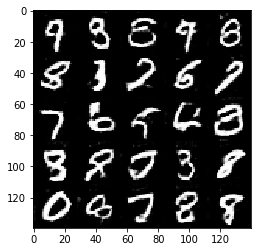

Epochs 2,batches 4010, dis_loss 0.9273121356964111 , gen_loss 1.671255350112915
Epochs 2,batches 4020, dis_loss 1.0271146297454834 , gen_loss 0.8456339836120605
Epochs 2,batches 4030, dis_loss 1.3564693927764893 , gen_loss 0.5316551923751831
Epochs 2,batches 4040, dis_loss 0.8660616874694824 , gen_loss 1.1747386455535889
Epochs 2,batches 4050, dis_loss 0.922895610332489 , gen_loss 0.9687116146087646
Epochs 2,batches 4060, dis_loss 0.7016772031784058 , gen_loss 1.4944977760314941
Epochs 2,batches 4070, dis_loss 0.7968063950538635 , gen_loss 1.5609509944915771
Epochs 2,batches 4080, dis_loss 0.8856863975524902 , gen_loss 2.150826930999756
Epochs 2,batches 4090, dis_loss 1.3774988651275635 , gen_loss 1.9895615577697754
Epochs 2,batches 4100, dis_loss 0.9719130992889404 , gen_loss 1.0221887826919556


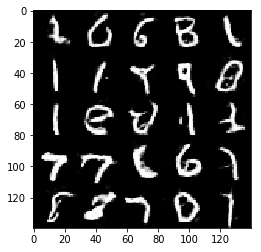

Epochs 2,batches 4110, dis_loss 0.9405841827392578 , gen_loss 1.4559121131896973
Epochs 2,batches 4120, dis_loss 0.906503438949585 , gen_loss 1.0384718179702759
Epochs 2,batches 4130, dis_loss 0.7707611322402954 , gen_loss 1.5852410793304443
Epochs 2,batches 4140, dis_loss 0.7056220769882202 , gen_loss 1.6145823001861572
Epochs 2,batches 4150, dis_loss 1.6010102033615112 , gen_loss 0.3485645651817322
Epochs 2,batches 4160, dis_loss 0.8533674478530884 , gen_loss 1.830480694770813
Epochs 2,batches 4170, dis_loss 1.0867223739624023 , gen_loss 0.7793511152267456
Epochs 2,batches 4180, dis_loss 0.9563394784927368 , gen_loss 1.03717041015625
Epochs 2,batches 4190, dis_loss 1.2593997716903687 , gen_loss 0.7557251453399658
Epochs 2,batches 4200, dis_loss 0.70316082239151 , gen_loss 1.6509788036346436


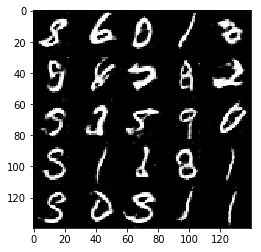

Epochs 2,batches 4210, dis_loss 0.9648014903068542 , gen_loss 0.9071585536003113
Epochs 2,batches 4220, dis_loss 1.757124423980713 , gen_loss 0.42875397205352783
Epochs 2,batches 4230, dis_loss 1.3626497983932495 , gen_loss 0.595820426940918
Epochs 2,batches 4240, dis_loss 1.522839903831482 , gen_loss 0.6564517021179199
Epochs 2,batches 4250, dis_loss 1.0203680992126465 , gen_loss 0.8620344400405884
Epochs 2,batches 4260, dis_loss 0.8591873645782471 , gen_loss 1.1547765731811523
Epochs 2,batches 4270, dis_loss 1.1140940189361572 , gen_loss 0.8434604406356812
Epochs 2,batches 4280, dis_loss 1.3314260244369507 , gen_loss 0.543185830116272
Epochs 2,batches 4290, dis_loss 1.028307318687439 , gen_loss 1.1014741659164429
Epochs 2,batches 4300, dis_loss 1.0675477981567383 , gen_loss 0.866424560546875


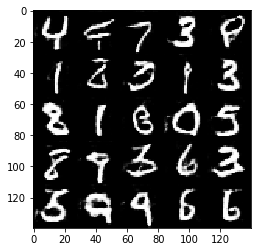

Epochs 2,batches 4310, dis_loss 0.6635830402374268 , gen_loss 1.5663305521011353
Epochs 2,batches 4320, dis_loss 0.8952118754386902 , gen_loss 0.9970269203186035
Epochs 2,batches 4330, dis_loss 1.1020562648773193 , gen_loss 0.7568269968032837
Epochs 2,batches 4340, dis_loss 0.839550256729126 , gen_loss 1.42939031124115
Epochs 2,batches 4350, dis_loss 0.706642210483551 , gen_loss 1.5953826904296875
Epochs 2,batches 4360, dis_loss 1.0505480766296387 , gen_loss 1.7982442378997803
Epochs 2,batches 4370, dis_loss 0.9454244375228882 , gen_loss 0.8470462560653687
Epochs 2,batches 4380, dis_loss 0.6355859041213989 , gen_loss 1.5189917087554932
Epochs 2,batches 4390, dis_loss 0.9842188358306885 , gen_loss 0.8931630849838257
Epochs 2,batches 4400, dis_loss 1.0575332641601562 , gen_loss 1.0822454690933228


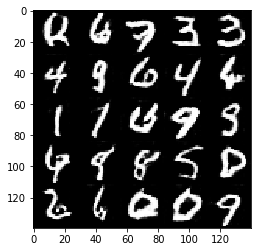

Epochs 2,batches 4410, dis_loss 1.0667314529418945 , gen_loss 1.0587966442108154
Epochs 2,batches 4420, dis_loss 1.6368062496185303 , gen_loss 0.3948225975036621
Epochs 2,batches 4430, dis_loss 1.089928150177002 , gen_loss 0.678938627243042
Epochs 2,batches 4440, dis_loss 0.7237728834152222 , gen_loss 1.5649173259735107
Epochs 2,batches 4450, dis_loss 0.9856147170066833 , gen_loss 1.3272504806518555
Epochs 2,batches 4460, dis_loss 0.7186916470527649 , gen_loss 1.6725497245788574
Epochs 2,batches 4470, dis_loss 0.734297513961792 , gen_loss 1.8060146570205688
Epochs 2,batches 4480, dis_loss 0.8730431199073792 , gen_loss 1.0187656879425049
Epochs 2,batches 4490, dis_loss 0.8962169885635376 , gen_loss 1.5493650436401367
Epochs 2,batches 4500, dis_loss 1.0376092195510864 , gen_loss 1.0376991033554077


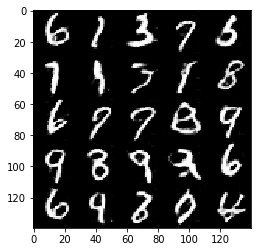

Epochs 2,batches 4510, dis_loss 0.7145078778266907 , gen_loss 1.5545531511306763
Epochs 2,batches 4520, dis_loss 0.8322917819023132 , gen_loss 1.2393572330474854
Epochs 2,batches 4530, dis_loss 0.7242285013198853 , gen_loss 2.11011004447937
Epochs 2,batches 4540, dis_loss 0.7783679962158203 , gen_loss 1.1263008117675781
Epochs 2,batches 4550, dis_loss 0.6545974016189575 , gen_loss 1.8995697498321533
Epochs 2,batches 4560, dis_loss 0.7577362060546875 , gen_loss 1.338428020477295
Epochs 2,batches 4570, dis_loss 1.0190082788467407 , gen_loss 1.3818273544311523
Epochs 2,batches 4580, dis_loss 1.1079916954040527 , gen_loss 1.3491337299346924
Epochs 2,batches 4590, dis_loss 0.8403588533401489 , gen_loss 1.3691773414611816
Epochs 2,batches 4600, dis_loss 0.8518567681312561 , gen_loss 0.9603358507156372


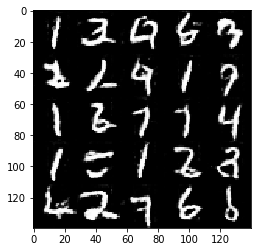

Epochs 2,batches 4610, dis_loss 0.8116294145584106 , gen_loss 1.2063705921173096
Epochs 2,batches 4620, dis_loss 1.2368522882461548 , gen_loss 0.7179864645004272
Epochs 2,batches 4630, dis_loss 1.2122490406036377 , gen_loss 0.7956326603889465
Epochs 2,batches 4640, dis_loss 0.8171201944351196 , gen_loss 1.4014003276824951
Epochs 2,batches 4650, dis_loss 0.7935841679573059 , gen_loss 1.219923496246338
Epochs 2,batches 4660, dis_loss 0.7122602462768555 , gen_loss 1.7632496356964111
Epochs 2,batches 4670, dis_loss 0.6521797180175781 , gen_loss 1.7560476064682007
Epochs 2,batches 4680, dis_loss 0.6904045343399048 , gen_loss 1.4986042976379395
Epochs 2,batches 4690, dis_loss 0.9709805250167847 , gen_loss 1.5063539743423462
Epochs 2,batches 4700, dis_loss 0.729831337928772 , gen_loss 1.5138463973999023


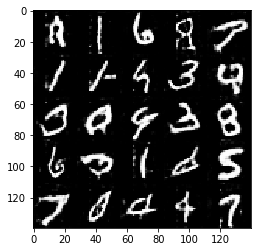

Epochs 2,batches 4710, dis_loss 1.014427661895752 , gen_loss 0.7635997533798218
Epochs 2,batches 4720, dis_loss 1.0291415452957153 , gen_loss 0.8078877925872803
Epochs 2,batches 4730, dis_loss 1.306921362876892 , gen_loss 0.5259711742401123
Epochs 2,batches 4740, dis_loss 0.9339849948883057 , gen_loss 0.9285215139389038
Epochs 2,batches 4750, dis_loss 0.8563240766525269 , gen_loss 1.4308083057403564
Epochs 2,batches 4760, dis_loss 0.5629749894142151 , gen_loss 1.8897652626037598
Epochs 2,batches 4770, dis_loss 0.7580430507659912 , gen_loss 1.0947844982147217
Epochs 2,batches 4780, dis_loss 0.9804585576057434 , gen_loss 1.3889185190200806
Epochs 2,batches 4790, dis_loss 0.8126763701438904 , gen_loss 2.056605577468872
Epochs 2,batches 4800, dis_loss 0.7258514165878296 , gen_loss 1.5733530521392822


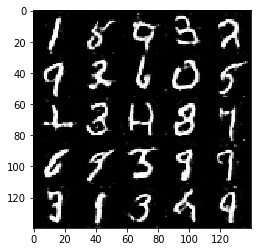

Epochs 2,batches 4810, dis_loss 0.8004881143569946 , gen_loss 1.164621114730835
Epochs 2,batches 4820, dis_loss 0.829473614692688 , gen_loss 1.1967332363128662
Epochs 2,batches 4830, dis_loss 0.7331395745277405 , gen_loss 1.3840219974517822
Epochs 2,batches 4840, dis_loss 0.9775496125221252 , gen_loss 0.7564026117324829
Epochs 2,batches 4850, dis_loss 1.3966639041900635 , gen_loss 0.7128625512123108
Epochs 2,batches 4860, dis_loss 1.1639958620071411 , gen_loss 0.8152264952659607
Epochs 2,batches 4870, dis_loss 1.7070503234863281 , gen_loss 0.33786115050315857
Epochs 2,batches 4880, dis_loss 1.191349744796753 , gen_loss 0.8891398906707764
Epochs 2,batches 4890, dis_loss 0.662941575050354 , gen_loss 1.6721148490905762
Epochs 2,batches 4900, dis_loss 0.9843217134475708 , gen_loss 0.8354777097702026


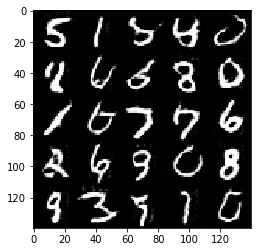

Epochs 2,batches 4910, dis_loss 0.9081584215164185 , gen_loss 1.2171642780303955
Epochs 2,batches 4920, dis_loss 0.7713913321495056 , gen_loss 1.2451525926589966
Epochs 2,batches 4930, dis_loss 0.6953887343406677 , gen_loss 1.1267935037612915
Epochs 2,batches 4940, dis_loss 0.9002707600593567 , gen_loss 1.3271493911743164
Epochs 2,batches 4950, dis_loss 1.2269132137298584 , gen_loss 0.8067169785499573
Epochs 2,batches 4960, dis_loss 0.7022789120674133 , gen_loss 1.6080353260040283
Epochs 2,batches 4970, dis_loss 1.3065303564071655 , gen_loss 0.5851775407791138
Epochs 2,batches 4980, dis_loss 0.6430752277374268 , gen_loss 2.229823112487793
Epochs 2,batches 4990, dis_loss 0.5698020458221436 , gen_loss 1.651840090751648
Epochs 2,batches 5000, dis_loss 1.1099356412887573 , gen_loss 0.97622150182724


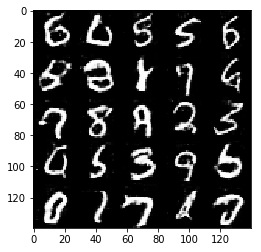

Epochs 2,batches 5010, dis_loss 0.796520471572876 , gen_loss 1.2651478052139282
Epochs 2,batches 5020, dis_loss 0.8073548078536987 , gen_loss 0.9733891487121582
Epochs 2,batches 5030, dis_loss 1.2510532140731812 , gen_loss 0.78298020362854
Epochs 2,batches 5040, dis_loss 0.8833366632461548 , gen_loss 1.1920931339263916
Epochs 2,batches 5050, dis_loss 0.7162685394287109 , gen_loss 1.3129663467407227
Epochs 2,batches 5060, dis_loss 1.0584380626678467 , gen_loss 0.7741423845291138
Epochs 2,batches 5070, dis_loss 0.8298028707504272 , gen_loss 1.5086097717285156
Epochs 2,batches 5080, dis_loss 0.8550926446914673 , gen_loss 1.0531282424926758
Epochs 2,batches 5090, dis_loss 1.2520902156829834 , gen_loss 0.7109401822090149
Epochs 2,batches 5100, dis_loss 0.7912783622741699 , gen_loss 1.675429105758667


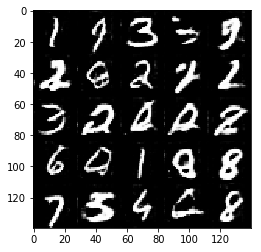

Epochs 2,batches 5110, dis_loss 0.5639969110488892 , gen_loss 1.820070505142212
Epochs 2,batches 5120, dis_loss 1.0633009672164917 , gen_loss 0.7635277509689331
Epochs 2,batches 5130, dis_loss 1.2043204307556152 , gen_loss 0.5661817789077759
Epochs 2,batches 5140, dis_loss 0.8335029482841492 , gen_loss 1.4348180294036865
Epochs 2,batches 5150, dis_loss 1.020926594734192 , gen_loss 0.7836503386497498
Epochs 2,batches 5160, dis_loss 0.6442780494689941 , gen_loss 1.8378410339355469
Epochs 2,batches 5170, dis_loss 1.4718573093414307 , gen_loss 0.5770841240882874
Epochs 2,batches 5180, dis_loss 1.0155233144760132 , gen_loss 0.8175270557403564
Epochs 2,batches 5190, dis_loss 1.1167742013931274 , gen_loss 0.6926038265228271
Epochs 2,batches 5200, dis_loss 1.0998358726501465 , gen_loss 0.7072193622589111


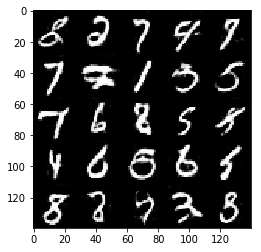

Epochs 2,batches 5210, dis_loss 0.8026710748672485 , gen_loss 1.5715572834014893
Epochs 2,batches 5220, dis_loss 0.8058124780654907 , gen_loss 1.484400987625122
Epochs 2,batches 5230, dis_loss 1.1361660957336426 , gen_loss 0.7398766279220581
Epochs 2,batches 5240, dis_loss 0.7460566759109497 , gen_loss 1.3408035039901733
Epochs 2,batches 5250, dis_loss 1.099348545074463 , gen_loss 0.7117297053337097
Epochs 2,batches 5260, dis_loss 0.8946712017059326 , gen_loss 1.2479171752929688
Epochs 2,batches 5270, dis_loss 1.002863883972168 , gen_loss 0.8613545894622803
Epochs 2,batches 5280, dis_loss 1.0235862731933594 , gen_loss 2.4243369102478027
Epochs 2,batches 5290, dis_loss 0.8571604490280151 , gen_loss 1.1062958240509033
Epochs 2,batches 5300, dis_loss 1.905928134918213 , gen_loss 0.32381248474121094


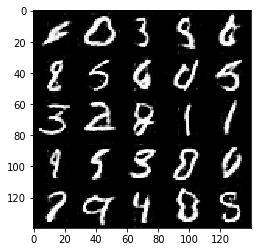

Epochs 2,batches 5310, dis_loss 1.365552544593811 , gen_loss 2.0596044063568115
Epochs 2,batches 5320, dis_loss 1.3764870166778564 , gen_loss 0.6019401550292969
Epochs 2,batches 5330, dis_loss 0.9547046422958374 , gen_loss 1.0819286108016968
Epochs 2,batches 5340, dis_loss 1.1074538230895996 , gen_loss 0.5921838283538818
Epochs 2,batches 5350, dis_loss 0.703992486000061 , gen_loss 1.3760571479797363
Epochs 2,batches 5360, dis_loss 0.6785584688186646 , gen_loss 1.2546343803405762
Epochs 2,batches 5370, dis_loss 0.7214356660842896 , gen_loss 1.7177867889404297
Epochs 2,batches 5380, dis_loss 0.6417953968048096 , gen_loss 1.7183051109313965
Epochs 2,batches 5390, dis_loss 0.7077593803405762 , gen_loss 1.5302536487579346
Epochs 2,batches 5400, dis_loss 1.2568806409835815 , gen_loss 0.7909183502197266


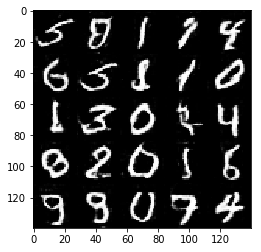

Epochs 2,batches 5410, dis_loss 1.0053058862686157 , gen_loss 2.164802312850952
Epochs 2,batches 5420, dis_loss 0.6757944226264954 , gen_loss 1.6845093965530396
Epochs 2,batches 5430, dis_loss 1.0720112323760986 , gen_loss 0.7036450505256653
Epochs 2,batches 5440, dis_loss 0.7472213506698608 , gen_loss 1.3755745887756348
Epochs 2,batches 5450, dis_loss 0.8835697174072266 , gen_loss 1.9611077308654785
Epochs 2,batches 5460, dis_loss 1.131208062171936 , gen_loss 2.050002336502075
Epochs 2,batches 5470, dis_loss 0.8924765586853027 , gen_loss 0.9542118310928345
Epochs 2,batches 5480, dis_loss 0.7510276436805725 , gen_loss 1.2808547019958496
Epochs 2,batches 5490, dis_loss 1.2749543190002441 , gen_loss 0.6822923421859741
Epochs 2,batches 5500, dis_loss 0.6303995847702026 , gen_loss 1.55366051197052


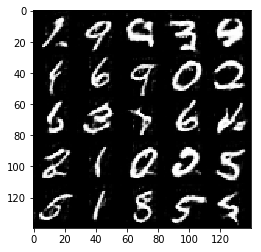

Epochs 2,batches 5510, dis_loss 1.0060625076293945 , gen_loss 1.1952193975448608
Epochs 2,batches 5520, dis_loss 0.7455646991729736 , gen_loss 1.52042555809021
Epochs 2,batches 5530, dis_loss 0.686526894569397 , gen_loss 1.6127681732177734
Epochs 2,batches 5540, dis_loss 0.6852777004241943 , gen_loss 1.6941049098968506
Epochs 2,batches 5550, dis_loss 1.1191824674606323 , gen_loss 0.6603371500968933
Epochs 2,batches 5560, dis_loss 0.8480992317199707 , gen_loss 0.9897012114524841
Epochs 2,batches 5570, dis_loss 0.9351590871810913 , gen_loss 1.2469087839126587
Epochs 2,batches 5580, dis_loss 0.7850041389465332 , gen_loss 1.336963176727295
Epochs 2,batches 5590, dis_loss 0.8406902551651001 , gen_loss 1.2898632287979126
Epochs 2,batches 5600, dis_loss 0.9323477745056152 , gen_loss 1.0097293853759766


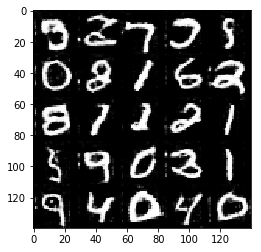

Epochs 2,batches 5610, dis_loss 0.8833277821540833 , gen_loss 1.0445536375045776
Epochs 2,batches 5620, dis_loss 0.7326291799545288 , gen_loss 1.264412522315979
Epochs 2,batches 5630, dis_loss 0.7691634893417358 , gen_loss 1.6137053966522217
Epochs 2,batches 5640, dis_loss 0.9304780960083008 , gen_loss 0.909508466720581
Epochs 2,batches 5650, dis_loss 0.8848670721054077 , gen_loss 1.2195881605148315
Epochs 2,batches 5660, dis_loss 0.6932474374771118 , gen_loss 1.3316943645477295
Epochs 2,batches 5670, dis_loss 0.8051496744155884 , gen_loss 2.39732027053833
Epochs 2,batches 5680, dis_loss 0.9261777997016907 , gen_loss 2.425077438354492
Epochs 2,batches 5690, dis_loss 1.2104055881500244 , gen_loss 0.7082037925720215
Epochs 2,batches 5700, dis_loss 0.6098553538322449 , gen_loss 1.663398027420044


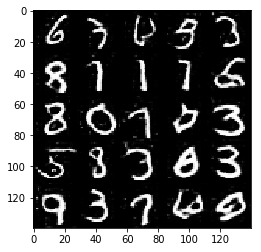

Epochs 2,batches 5710, dis_loss 0.8026496171951294 , gen_loss 1.5221014022827148
Epochs 2,batches 5720, dis_loss 1.105284571647644 , gen_loss 0.7948504090309143
Epochs 2,batches 5730, dis_loss 0.9902750849723816 , gen_loss 0.9687198996543884
Epochs 2,batches 5740, dis_loss 0.7870404720306396 , gen_loss 1.3065954446792603
Epochs 2,batches 5750, dis_loss 0.8101701736450195 , gen_loss 1.114287257194519
Epochs 2,batches 5760, dis_loss 0.6548625230789185 , gen_loss 1.1162385940551758
Epochs 2,batches 5770, dis_loss 0.6262293457984924 , gen_loss 1.9773508310317993
Epochs 2,batches 5780, dis_loss 0.7898403406143188 , gen_loss 1.234279751777649
Epochs 2,batches 5790, dis_loss 0.9865570664405823 , gen_loss 1.4173107147216797
Epochs 2,batches 5800, dis_loss 0.8590548634529114 , gen_loss 1.4937329292297363


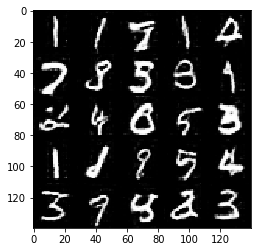

Epochs 2,batches 5810, dis_loss 0.6958342790603638 , gen_loss 1.3678884506225586
Epochs 2,batches 5820, dis_loss 0.6955410838127136 , gen_loss 1.455209732055664
Epochs 2,batches 5830, dis_loss 1.1504285335540771 , gen_loss 0.663485050201416
Epochs 2,batches 5840, dis_loss 0.7221916913986206 , gen_loss 1.3316304683685303
Epochs 2,batches 5850, dis_loss 1.0311024188995361 , gen_loss 0.7631668448448181
Epochs 2,batches 5860, dis_loss 1.6575343608856201 , gen_loss 0.4741361737251282
Epochs 2,batches 5870, dis_loss 0.7049254179000854 , gen_loss 2.198976755142212
Epochs 2,batches 5880, dis_loss 0.9227278232574463 , gen_loss 2.183389186859131
Epochs 2,batches 5890, dis_loss 0.8622646927833557 , gen_loss 1.1430649757385254
Epochs 2,batches 5900, dis_loss 0.49621880054473877 , gen_loss 2.269406318664551


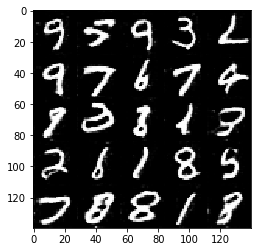

Epochs 2,batches 5910, dis_loss 1.0804786682128906 , gen_loss 0.7096835374832153
Epochs 2,batches 5920, dis_loss 0.9283186197280884 , gen_loss 0.9733492136001587
Epochs 2,batches 5930, dis_loss 0.7412891387939453 , gen_loss 1.7363866567611694
Epochs 2,batches 5940, dis_loss 0.6582996845245361 , gen_loss 2.1989028453826904
Epochs 2,batches 5950, dis_loss 0.9414023160934448 , gen_loss 0.9466924071311951
Epochs 2,batches 5960, dis_loss 0.8643022775650024 , gen_loss 1.472244143486023
Epochs 2,batches 5970, dis_loss 1.2143914699554443 , gen_loss 0.6378757953643799
Epochs 2,batches 5980, dis_loss 0.7099016904830933 , gen_loss 1.5315158367156982
Epochs 2,batches 5990, dis_loss 0.747157871723175 , gen_loss 1.5209482908248901
Epochs 2,batches 6000, dis_loss 0.8141990900039673 , gen_loss 1.6343092918395996


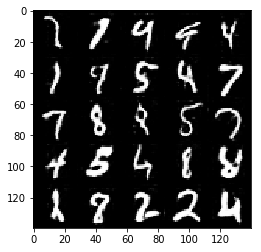

Epochs 2,batches 6010, dis_loss 0.9066004753112793 , gen_loss 1.0213282108306885
Epochs 2,batches 6020, dis_loss 0.8888120651245117 , gen_loss 1.5601005554199219
Epochs 2,batches 6030, dis_loss 2.0361204147338867 , gen_loss 3.8734054565429688
Epochs 2,batches 6040, dis_loss 0.8507777452468872 , gen_loss 1.3415181636810303
Epochs 2,batches 6050, dis_loss 0.8844860792160034 , gen_loss 1.6174073219299316
Epochs 2,batches 6060, dis_loss 0.6847546100616455 , gen_loss 1.350261926651001
Epochs 2,batches 6070, dis_loss 0.8185582160949707 , gen_loss 1.157836675643921
Epochs 2,batches 6080, dis_loss 0.6088664531707764 , gen_loss 1.7819783687591553
Epochs 2,batches 6090, dis_loss 0.6365934014320374 , gen_loss 1.7170026302337646
Epochs 2,batches 6100, dis_loss 0.6707615852355957 , gen_loss 1.3999451398849487


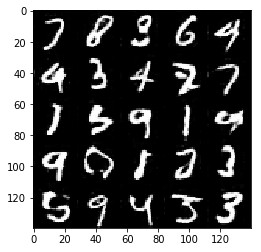

Epochs 2,batches 6110, dis_loss 0.7039609551429749 , gen_loss 1.8375828266143799
Epochs 2,batches 6120, dis_loss 0.5865694880485535 , gen_loss 2.144965171813965
Epochs 2,batches 6130, dis_loss 1.318693995475769 , gen_loss 0.6120190024375916
Epochs 2,batches 6140, dis_loss 1.016856074333191 , gen_loss 0.9124134182929993
Epochs 2,batches 6150, dis_loss 0.846900224685669 , gen_loss 1.554811716079712
Epochs 2,batches 6160, dis_loss 0.6556259989738464 , gen_loss 1.5601320266723633
Epochs 2,batches 6170, dis_loss 0.6799721717834473 , gen_loss 1.4367347955703735
Epochs 2,batches 6180, dis_loss 0.9258461594581604 , gen_loss 0.9607275724411011
Epochs 2,batches 6190, dis_loss 0.7543940544128418 , gen_loss 1.4996718168258667
Epochs 2,batches 6200, dis_loss 0.6242422461509705 , gen_loss 1.8793309926986694


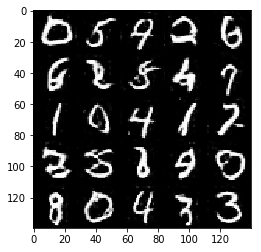

Epochs 2,batches 6210, dis_loss 0.9286558628082275 , gen_loss 0.9123088717460632
Epochs 2,batches 6220, dis_loss 0.620202898979187 , gen_loss 1.7779173851013184
Epochs 2,batches 6230, dis_loss 0.7359911203384399 , gen_loss 1.3904743194580078
Epochs 2,batches 6240, dis_loss 0.7910507917404175 , gen_loss 1.426734209060669
Epochs 2,batches 6250, dis_loss 0.8560770750045776 , gen_loss 1.588607668876648
Epochs 2,batches 6260, dis_loss 0.7333401441574097 , gen_loss 1.4965438842773438
Epochs 2,batches 6270, dis_loss 0.7449007034301758 , gen_loss 1.33628511428833
Epochs 2,batches 6280, dis_loss 1.0112557411193848 , gen_loss 0.8305829763412476
Epochs 2,batches 6290, dis_loss 0.731498658657074 , gen_loss 1.2267308235168457
Epochs 2,batches 6300, dis_loss 0.6607385277748108 , gen_loss 1.6424384117126465


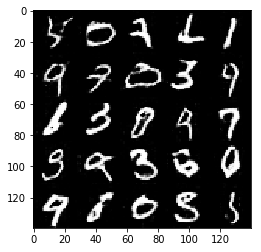

Epochs 2,batches 6310, dis_loss 0.5517787933349609 , gen_loss 1.504961371421814
Epochs 2,batches 6320, dis_loss 0.8920133113861084 , gen_loss 1.0624206066131592
Epochs 2,batches 6330, dis_loss 1.0383110046386719 , gen_loss 0.9613597393035889
Epochs 2,batches 6340, dis_loss 0.920914888381958 , gen_loss 1.5956673622131348
Epochs 2,batches 6350, dis_loss 1.5035744905471802 , gen_loss 0.4103177785873413
Epochs 2,batches 6360, dis_loss 0.7416396141052246 , gen_loss 2.135704755783081
Epochs 2,batches 6370, dis_loss 0.9372869729995728 , gen_loss 0.9375677108764648
Epochs 2,batches 6380, dis_loss 0.6864538192749023 , gen_loss 2.2945237159729004
Epochs 2,batches 6390, dis_loss 1.0224602222442627 , gen_loss 0.9970353841781616
Epochs 2,batches 6400, dis_loss 0.613576352596283 , gen_loss 2.2362146377563477


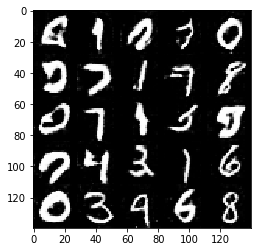

Epochs 2,batches 6410, dis_loss 1.5721628665924072 , gen_loss 0.3864203989505768
Epochs 2,batches 6420, dis_loss 0.9939281940460205 , gen_loss 0.9926286935806274
Epochs 2,batches 6430, dis_loss 0.9687492847442627 , gen_loss 1.0195478200912476
Epochs 2,batches 6440, dis_loss 0.9936351776123047 , gen_loss 0.8571805953979492
Epochs 2,batches 6450, dis_loss 0.7707839608192444 , gen_loss 1.610216498374939
Epochs 2,batches 6460, dis_loss 0.9190523624420166 , gen_loss 1.0230026245117188
Epochs 2,batches 6470, dis_loss 0.8961622714996338 , gen_loss 1.1099950075149536
Epochs 2,batches 6480, dis_loss 0.9515015482902527 , gen_loss 2.2864105701446533
Epochs 2,batches 6490, dis_loss 0.9524216055870056 , gen_loss 0.9456386566162109
Epochs 2,batches 6500, dis_loss 0.8957457542419434 , gen_loss 0.9402027130126953


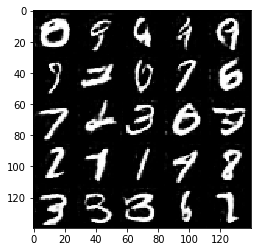

Epochs 2,batches 6510, dis_loss 0.7064885497093201 , gen_loss 1.5820016860961914
Epochs 2,batches 6520, dis_loss 0.6583075523376465 , gen_loss 1.540294885635376
Epochs 2,batches 6530, dis_loss 0.6899318695068359 , gen_loss 1.4115543365478516
Epochs 2,batches 6540, dis_loss 0.8543344736099243 , gen_loss 1.040439248085022
Epochs 2,batches 6550, dis_loss 0.7516067028045654 , gen_loss 1.5843827724456787
Epochs 2,batches 6560, dis_loss 0.7153974771499634 , gen_loss 1.4824802875518799
Epochs 2,batches 6570, dis_loss 0.8736866116523743 , gen_loss 0.7801158428192139
Epochs 2,batches 6580, dis_loss 0.8095102310180664 , gen_loss 1.2715420722961426
Epochs 2,batches 6590, dis_loss 0.8954548239707947 , gen_loss 2.7974846363067627
Epochs 2,batches 6600, dis_loss 1.1015386581420898 , gen_loss 0.6035579442977905


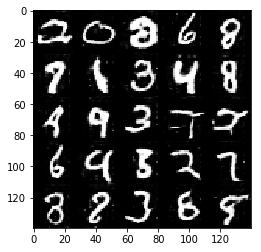

Epochs 2,batches 6610, dis_loss 0.8103856444358826 , gen_loss 1.6930017471313477
Epochs 2,batches 6620, dis_loss 0.7511562705039978 , gen_loss 1.1611261367797852
Epochs 2,batches 6630, dis_loss 0.6563063859939575 , gen_loss 1.3451378345489502
Epochs 2,batches 6640, dis_loss 0.8445765972137451 , gen_loss 1.462782382965088
Epochs 2,batches 6650, dis_loss 0.6553518772125244 , gen_loss 1.5809812545776367
Epochs 2,batches 6660, dis_loss 0.7016369104385376 , gen_loss 1.30635666847229
Epochs 2,batches 6670, dis_loss 0.7760863304138184 , gen_loss 1.4953279495239258
Epochs 2,batches 6680, dis_loss 0.7403473854064941 , gen_loss 1.1852775812149048
Epochs 2,batches 6690, dis_loss 0.774502158164978 , gen_loss 1.26338791847229
Epochs 2,batches 6700, dis_loss 0.8475685715675354 , gen_loss 1.2829580307006836


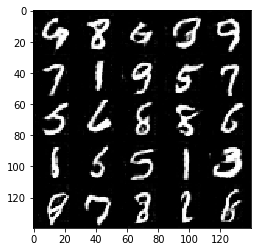

Epochs 2,batches 6710, dis_loss 0.5457553267478943 , gen_loss 1.8270795345306396
Epochs 2,batches 6720, dis_loss 0.6248047947883606 , gen_loss 2.568826198577881
Epochs 2,batches 6730, dis_loss 0.6532844305038452 , gen_loss 2.231172561645508
Epochs 2,batches 6740, dis_loss 1.2723302841186523 , gen_loss 0.6159206628799438
Epochs 2,batches 6750, dis_loss 0.9766111969947815 , gen_loss 1.1216404438018799
Epochs 2,batches 6760, dis_loss 0.8265233635902405 , gen_loss 1.3916512727737427
Epochs 2,batches 6770, dis_loss 1.1662272214889526 , gen_loss 0.8483428955078125
Epochs 2,batches 6780, dis_loss 0.672762393951416 , gen_loss 1.6556681394577026
Epochs 2,batches 6790, dis_loss 0.6741950511932373 , gen_loss 1.558669090270996
Epochs 2,batches 6800, dis_loss 0.6802441477775574 , gen_loss 1.7285568714141846


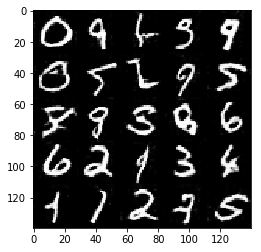

Epochs 2,batches 6810, dis_loss 0.7825788855552673 , gen_loss 2.2248477935791016
Epochs 2,batches 6820, dis_loss 0.6312022805213928 , gen_loss 1.5884922742843628
Epochs 2,batches 6830, dis_loss 0.6158789396286011 , gen_loss 2.3965554237365723
Epochs 2,batches 6840, dis_loss 1.2135084867477417 , gen_loss 0.5732319355010986
Epochs 2,batches 6850, dis_loss 0.7647254467010498 , gen_loss 1.4141833782196045
Epochs 2,batches 6860, dis_loss 0.8688945770263672 , gen_loss 0.9026910662651062
Epochs 2,batches 6870, dis_loss 1.3276960849761963 , gen_loss 0.5957624912261963
Epochs 2,batches 6880, dis_loss 0.5792132616043091 , gen_loss 2.069288969039917
Epochs 2,batches 6890, dis_loss 0.9871534109115601 , gen_loss 1.3618216514587402
Epochs 2,batches 6900, dis_loss 0.6332001090049744 , gen_loss 1.9716768264770508


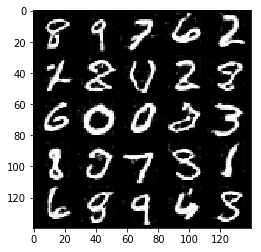

Epochs 2,batches 6910, dis_loss 0.8525083661079407 , gen_loss 2.042508840560913
Epochs 2,batches 6920, dis_loss 1.2583308219909668 , gen_loss 0.6709204912185669
Epochs 2,batches 6930, dis_loss 0.89244544506073 , gen_loss 1.2107102870941162
Epochs 2,batches 6940, dis_loss 0.715624213218689 , gen_loss 1.5316481590270996
Epochs 2,batches 6950, dis_loss 0.8020784854888916 , gen_loss 2.7572059631347656
Epochs 2,batches 6960, dis_loss 0.9325060844421387 , gen_loss 0.8452449440956116
Epochs 2,batches 6970, dis_loss 1.3807681798934937 , gen_loss 3.235945701599121
Epochs 2,batches 6980, dis_loss 0.7167454361915588 , gen_loss 2.1476383209228516
Epochs 2,batches 6990, dis_loss 1.1413390636444092 , gen_loss 0.7266470789909363
Epochs 2,batches 7000, dis_loss 0.6993057727813721 , gen_loss 1.5173566341400146


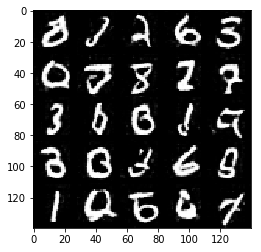

Epochs 2,batches 7010, dis_loss 1.06467604637146 , gen_loss 0.7762195467948914
Epochs 2,batches 7020, dis_loss 0.7903361320495605 , gen_loss 1.1735763549804688
Epochs 2,batches 7030, dis_loss 0.8083797693252563 , gen_loss 1.106886863708496
Epochs 2,batches 7040, dis_loss 0.6347799301147461 , gen_loss 1.834062099456787
Epochs 2,batches 7050, dis_loss 0.6202702522277832 , gen_loss 1.606837511062622
Epochs 2,batches 7060, dis_loss 0.6559770107269287 , gen_loss 1.699082374572754
Epochs 2,batches 7070, dis_loss 0.784150242805481 , gen_loss 1.295149803161621
Epochs 2,batches 7080, dis_loss 0.6461807489395142 , gen_loss 1.9526610374450684
Epochs 2,batches 7090, dis_loss 1.8094384670257568 , gen_loss 0.4578571915626526
Epochs 2,batches 7100, dis_loss 0.7073096632957458 , gen_loss 1.2997262477874756


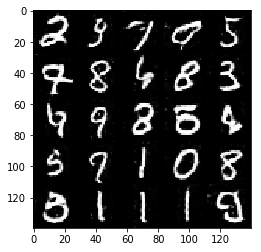

Epochs 2,batches 7110, dis_loss 0.5730201005935669 , gen_loss 1.685023307800293
Epochs 2,batches 7120, dis_loss 0.7057927846908569 , gen_loss 1.4526437520980835
Epochs 2,batches 7130, dis_loss 1.2292766571044922 , gen_loss 0.7094970941543579
Epochs 2,batches 7140, dis_loss 0.9908021092414856 , gen_loss 0.8461228013038635
Epochs 2,batches 7150, dis_loss 0.8598233461380005 , gen_loss 1.9302433729171753
Epochs 2,batches 7160, dis_loss 0.6011084914207458 , gen_loss 1.652984857559204
Epochs 2,batches 7170, dis_loss 0.7161942720413208 , gen_loss 2.8409056663513184
Epochs 2,batches 7180, dis_loss 0.7182698249816895 , gen_loss 1.7594044208526611
Epochs 2,batches 7190, dis_loss 0.7098658680915833 , gen_loss 4.071361541748047
Epochs 2,batches 7200, dis_loss 1.0767658948898315 , gen_loss 1.1015833616256714


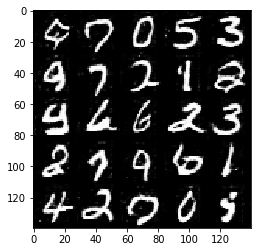

Epochs 2,batches 7210, dis_loss 0.8165314793586731 , gen_loss 1.7461178302764893
Epochs 2,batches 7220, dis_loss 0.44720950722694397 , gen_loss 2.442424774169922
Epochs 2,batches 7230, dis_loss 0.8658924698829651 , gen_loss 0.9434479475021362
Epochs 2,batches 7240, dis_loss 0.7646960020065308 , gen_loss 1.3348052501678467
Epochs 2,batches 7250, dis_loss 0.6138910055160522 , gen_loss 1.792040228843689
Epochs 2,batches 7260, dis_loss 0.6678256988525391 , gen_loss 1.719521403312683
Epochs 2,batches 7270, dis_loss 1.2833279371261597 , gen_loss 0.6800187826156616
Epochs 2,batches 7280, dis_loss 0.8628518581390381 , gen_loss 1.0427110195159912
Epochs 2,batches 7290, dis_loss 1.212125539779663 , gen_loss 0.9247636795043945
Epochs 2,batches 7300, dis_loss 0.9724678993225098 , gen_loss 0.8272750377655029


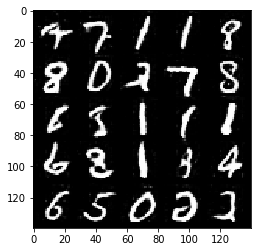

Epochs 2,batches 7310, dis_loss 1.3002644777297974 , gen_loss 3.1230921745300293
Epochs 2,batches 7320, dis_loss 1.141785740852356 , gen_loss 0.695436954498291
Epochs 2,batches 7330, dis_loss 0.7131380438804626 , gen_loss 1.286031723022461
Epochs 2,batches 7340, dis_loss 0.7811696529388428 , gen_loss 1.3801841735839844
Epochs 2,batches 7350, dis_loss 1.0211987495422363 , gen_loss 0.575732946395874
Epochs 2,batches 7360, dis_loss 1.2411108016967773 , gen_loss 0.7902358174324036
Epochs 2,batches 7370, dis_loss 0.7711191177368164 , gen_loss 1.5037312507629395
Epochs 2,batches 7380, dis_loss 0.9810949563980103 , gen_loss 0.8324998617172241
Epochs 2,batches 7390, dis_loss 0.6408427357673645 , gen_loss 1.9942209720611572
Epochs 2,batches 7400, dis_loss 0.8204915523529053 , gen_loss 1.42717444896698


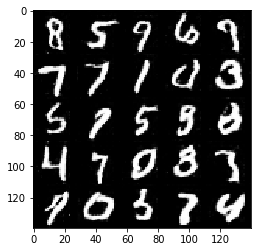

Epochs 2,batches 7410, dis_loss 0.8897542953491211 , gen_loss 1.1287437677383423
Epochs 2,batches 7420, dis_loss 0.5093857049942017 , gen_loss 2.045248031616211
Epochs 2,batches 7430, dis_loss 0.9253153204917908 , gen_loss 1.2486071586608887
Epochs 2,batches 7440, dis_loss 0.6303718090057373 , gen_loss 1.4448232650756836
Epochs 2,batches 7450, dis_loss 0.8750086426734924 , gen_loss 0.919594407081604
Epochs 2,batches 7460, dis_loss 0.881476104259491 , gen_loss 1.2884407043457031
Epochs 2,batches 7470, dis_loss 0.9346277117729187 , gen_loss 1.1436264514923096
Epochs 2,batches 7480, dis_loss 0.8330304026603699 , gen_loss 1.3499295711517334
Epochs 2,batches 7490, dis_loss 0.7007361650466919 , gen_loss 1.7628501653671265
Epochs 2,batches 7500, dis_loss 0.894546627998352 , gen_loss 1.3325207233428955


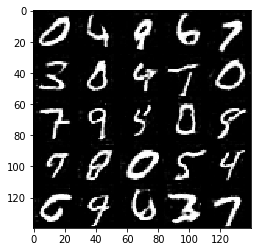

In [20]:
batch_size = 16
z_dim = 130
learning_rate = 0.0004
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


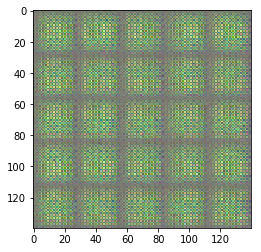

Epochs 1,batches 10, dis_loss 3.060817241668701 , gen_loss 0.11390362679958344
Epochs 1,batches 20, dis_loss 4.67816162109375 , gen_loss 0.0195348858833313
Epochs 1,batches 30, dis_loss 1.9100847244262695 , gen_loss 0.3841496407985687
Epochs 1,batches 40, dis_loss 2.220750331878662 , gen_loss 0.24578562378883362
Epochs 1,batches 50, dis_loss 2.4877307415008545 , gen_loss 3.7764947414398193
Epochs 1,batches 60, dis_loss 1.3844563961029053 , gen_loss 1.362552523612976
Epochs 1,batches 70, dis_loss 1.2285175323486328 , gen_loss 1.1330755949020386
Epochs 1,batches 80, dis_loss 1.542306661605835 , gen_loss 0.5028343796730042
Epochs 1,batches 90, dis_loss 1.3879995346069336 , gen_loss 0.6927470564842224
Epochs 1,batches 100, dis_loss 1.8983758687973022 , gen_loss 0.31077009439468384


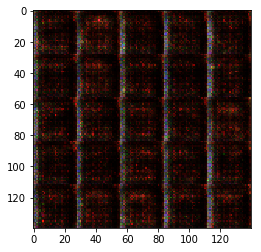

Epochs 1,batches 110, dis_loss 1.6633543968200684 , gen_loss 0.6525086164474487
Epochs 1,batches 120, dis_loss 1.982055902481079 , gen_loss 0.35225704312324524
Epochs 1,batches 130, dis_loss 1.454004168510437 , gen_loss 0.7565598487854004
Epochs 1,batches 140, dis_loss 1.8110817670822144 , gen_loss 1.829653263092041
Epochs 1,batches 150, dis_loss 1.5176194906234741 , gen_loss 1.0958268642425537
Epochs 1,batches 160, dis_loss 1.5268166065216064 , gen_loss 1.4469300508499146
Epochs 1,batches 170, dis_loss 1.2980741262435913 , gen_loss 1.0595717430114746
Epochs 1,batches 180, dis_loss 1.5272419452667236 , gen_loss 0.7017686367034912
Epochs 1,batches 190, dis_loss 1.6812516450881958 , gen_loss 0.40743401646614075
Epochs 1,batches 200, dis_loss 1.665670394897461 , gen_loss 2.1249537467956543


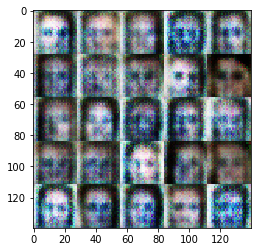

Epochs 1,batches 210, dis_loss 1.2771587371826172 , gen_loss 1.390044093132019
Epochs 1,batches 220, dis_loss 1.5195595026016235 , gen_loss 0.7667615413665771
Epochs 1,batches 230, dis_loss 1.351474642753601 , gen_loss 0.7446579933166504
Epochs 1,batches 240, dis_loss 1.5640548467636108 , gen_loss 0.4785662591457367
Epochs 1,batches 250, dis_loss 1.7663649320602417 , gen_loss 0.3423178791999817
Epochs 1,batches 260, dis_loss 1.608866810798645 , gen_loss 0.4222869873046875
Epochs 1,batches 270, dis_loss 1.4242844581604004 , gen_loss 0.7430980801582336
Epochs 1,batches 280, dis_loss 1.5472371578216553 , gen_loss 0.634651780128479
Epochs 1,batches 290, dis_loss 1.2395851612091064 , gen_loss 0.8278911709785461
Epochs 1,batches 300, dis_loss 1.6700775623321533 , gen_loss 1.427219271659851


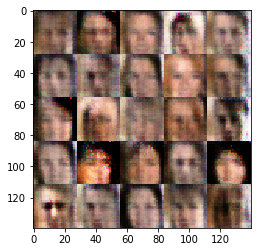

Epochs 1,batches 310, dis_loss 1.6001672744750977 , gen_loss 1.4582102298736572
Epochs 1,batches 320, dis_loss 1.4601962566375732 , gen_loss 0.7707818746566772
Epochs 1,batches 330, dis_loss 1.5552544593811035 , gen_loss 0.7740417122840881
Epochs 1,batches 340, dis_loss 1.5425970554351807 , gen_loss 1.0267484188079834
Epochs 1,batches 350, dis_loss 1.5131090879440308 , gen_loss 0.8958307504653931
Epochs 1,batches 360, dis_loss 1.2700496912002563 , gen_loss 0.6986640095710754
Epochs 1,batches 370, dis_loss 1.5856964588165283 , gen_loss 0.4383648633956909
Epochs 1,batches 380, dis_loss 1.4075945615768433 , gen_loss 0.940433919429779
Epochs 1,batches 390, dis_loss 1.5804474353790283 , gen_loss 0.44866451621055603
Epochs 1,batches 400, dis_loss 1.4734865427017212 , gen_loss 0.8429003953933716


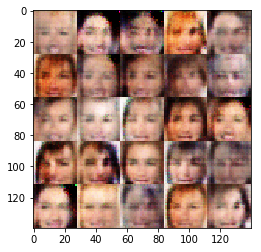

Epochs 1,batches 410, dis_loss 1.6344149112701416 , gen_loss 1.2561273574829102
Epochs 1,batches 420, dis_loss 1.4121294021606445 , gen_loss 0.8094449043273926
Epochs 1,batches 430, dis_loss 1.4079008102416992 , gen_loss 0.680810809135437
Epochs 1,batches 440, dis_loss 1.3214417695999146 , gen_loss 0.930001974105835
Epochs 1,batches 450, dis_loss 1.4479769468307495 , gen_loss 0.5701149106025696
Epochs 1,batches 460, dis_loss 1.4175466299057007 , gen_loss 0.7666881084442139
Epochs 1,batches 470, dis_loss 1.347205638885498 , gen_loss 0.7716599106788635
Epochs 1,batches 480, dis_loss 1.6604421138763428 , gen_loss 0.5223495960235596
Epochs 1,batches 490, dis_loss 1.5884277820587158 , gen_loss 0.5103762149810791
Epochs 1,batches 500, dis_loss 1.31783127784729 , gen_loss 0.8510353565216064


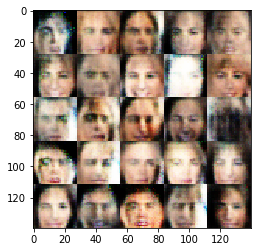

Epochs 1,batches 510, dis_loss 1.5578124523162842 , gen_loss 0.5181026458740234
Epochs 1,batches 520, dis_loss 1.3750113248825073 , gen_loss 0.601942777633667
Epochs 1,batches 530, dis_loss 1.508178472518921 , gen_loss 0.6680477857589722
Epochs 1,batches 540, dis_loss 1.4385181665420532 , gen_loss 0.5825878381729126
Epochs 1,batches 550, dis_loss 1.3617010116577148 , gen_loss 0.8994579315185547
Epochs 1,batches 560, dis_loss 1.423581838607788 , gen_loss 0.7404787540435791
Epochs 1,batches 570, dis_loss 1.548719882965088 , gen_loss 0.6001237630844116
Epochs 1,batches 580, dis_loss 1.371059775352478 , gen_loss 0.9244316816329956
Epochs 1,batches 590, dis_loss 1.4507626295089722 , gen_loss 0.6340663433074951
Epochs 1,batches 600, dis_loss 1.422314167022705 , gen_loss 0.6411495208740234


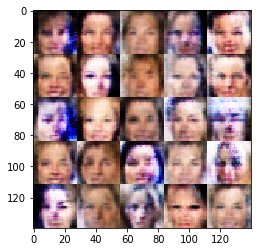

Epochs 1,batches 610, dis_loss 1.4152016639709473 , gen_loss 0.6557514071464539
Epochs 1,batches 620, dis_loss 1.448811411857605 , gen_loss 0.6370843052864075
Epochs 1,batches 630, dis_loss 1.3400402069091797 , gen_loss 1.067589521408081
Epochs 1,batches 640, dis_loss 1.474766492843628 , gen_loss 1.4083967208862305
Epochs 1,batches 650, dis_loss 1.4422472715377808 , gen_loss 0.5985996723175049
Epochs 1,batches 660, dis_loss 1.4029929637908936 , gen_loss 0.9396923780441284
Epochs 1,batches 670, dis_loss 1.4433460235595703 , gen_loss 0.6451600790023804
Epochs 1,batches 680, dis_loss 1.3836002349853516 , gen_loss 0.6922050714492798
Epochs 1,batches 690, dis_loss 1.387252926826477 , gen_loss 0.8278811573982239
Epochs 1,batches 700, dis_loss 1.460595726966858 , gen_loss 1.247542381286621


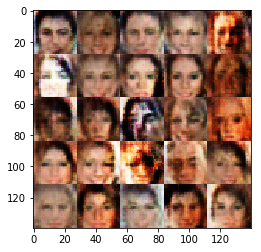

Epochs 1,batches 710, dis_loss 1.4806671142578125 , gen_loss 0.8700971603393555
Epochs 1,batches 720, dis_loss 1.5758696794509888 , gen_loss 0.9806554317474365
Epochs 1,batches 730, dis_loss 1.2996532917022705 , gen_loss 0.8021469116210938
Epochs 1,batches 740, dis_loss 1.3357000350952148 , gen_loss 0.711508572101593
Epochs 1,batches 750, dis_loss 1.559577465057373 , gen_loss 0.686368465423584
Epochs 1,batches 760, dis_loss 1.4128975868225098 , gen_loss 0.9431439638137817
Epochs 1,batches 770, dis_loss 1.4004889726638794 , gen_loss 1.2050625085830688
Epochs 1,batches 780, dis_loss 1.4662524461746216 , gen_loss 0.9920357465744019
Epochs 1,batches 790, dis_loss 1.4154770374298096 , gen_loss 0.8118181824684143
Epochs 1,batches 800, dis_loss 1.4203952550888062 , gen_loss 0.6309918165206909


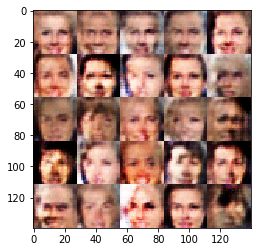

Epochs 1,batches 810, dis_loss 1.5129547119140625 , gen_loss 0.5094496607780457
Epochs 1,batches 820, dis_loss 1.392872929573059 , gen_loss 0.8167881965637207
Epochs 1,batches 830, dis_loss 1.338064193725586 , gen_loss 0.7605345249176025
Epochs 1,batches 840, dis_loss 1.3809536695480347 , gen_loss 0.7846698760986328
Epochs 1,batches 850, dis_loss 1.282884120941162 , gen_loss 0.6937963962554932
Epochs 1,batches 860, dis_loss 1.365723729133606 , gen_loss 0.7476465702056885
Epochs 1,batches 870, dis_loss 1.3054516315460205 , gen_loss 1.1038761138916016
Epochs 1,batches 880, dis_loss 1.3879746198654175 , gen_loss 0.8791049718856812
Epochs 1,batches 890, dis_loss 1.4571659564971924 , gen_loss 0.7336804866790771
Epochs 1,batches 900, dis_loss 1.417027235031128 , gen_loss 0.8524731993675232


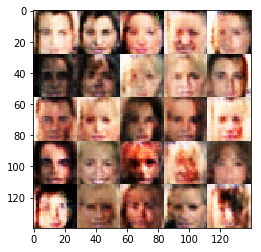

Epochs 1,batches 910, dis_loss 1.5320820808410645 , gen_loss 0.5223565101623535
Epochs 1,batches 920, dis_loss 1.4096554517745972 , gen_loss 0.6660751104354858
Epochs 1,batches 930, dis_loss 1.4507520198822021 , gen_loss 0.8390056490898132
Epochs 1,batches 940, dis_loss 1.2743229866027832 , gen_loss 0.8899267315864563
Epochs 1,batches 950, dis_loss 1.4106390476226807 , gen_loss 0.751818060874939
Epochs 1,batches 960, dis_loss 1.3799586296081543 , gen_loss 0.778983473777771
Epochs 1,batches 970, dis_loss 1.3635550737380981 , gen_loss 0.8758621215820312
Epochs 1,batches 980, dis_loss 1.399753212928772 , gen_loss 0.7691187262535095
Epochs 1,batches 990, dis_loss 1.3547112941741943 , gen_loss 0.9090800881385803
Epochs 1,batches 1000, dis_loss 1.4500365257263184 , gen_loss 1.2290380001068115


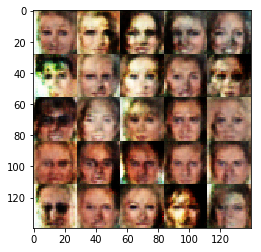

Epochs 1,batches 1010, dis_loss 1.3273261785507202 , gen_loss 0.8134852051734924
Epochs 1,batches 1020, dis_loss 1.4017301797866821 , gen_loss 0.6347294449806213
Epochs 1,batches 1030, dis_loss 1.483208179473877 , gen_loss 0.5540361404418945
Epochs 1,batches 1040, dis_loss 1.4310784339904785 , gen_loss 0.9110996723175049
Epochs 1,batches 1050, dis_loss 1.391554355621338 , gen_loss 0.6499897241592407
Epochs 1,batches 1060, dis_loss 1.5088545083999634 , gen_loss 0.5107792019844055
Epochs 1,batches 1070, dis_loss 1.4405043125152588 , gen_loss 0.6593166589736938
Epochs 1,batches 1080, dis_loss 1.3790665864944458 , gen_loss 1.0431462526321411
Epochs 1,batches 1090, dis_loss 1.433377981185913 , gen_loss 0.8068905472755432
Epochs 1,batches 1100, dis_loss 1.4735945463180542 , gen_loss 1.0034488439559937


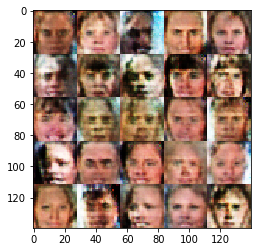

Epochs 1,batches 1110, dis_loss 1.5520710945129395 , gen_loss 0.4547662138938904
Epochs 1,batches 1120, dis_loss 1.3396005630493164 , gen_loss 0.7175517082214355
Epochs 1,batches 1130, dis_loss 1.3168847560882568 , gen_loss 0.6695890426635742
Epochs 1,batches 1140, dis_loss 1.494773268699646 , gen_loss 0.7225396037101746
Epochs 1,batches 1150, dis_loss 1.3302239179611206 , gen_loss 0.9591659307479858
Epochs 1,batches 1160, dis_loss 1.32179594039917 , gen_loss 0.8010420799255371
Epochs 1,batches 1170, dis_loss 1.3776856660842896 , gen_loss 0.6243883371353149
Epochs 1,batches 1180, dis_loss 1.3192472457885742 , gen_loss 0.9280992150306702
Epochs 1,batches 1190, dis_loss 1.3200823068618774 , gen_loss 0.8482340574264526
Epochs 1,batches 1200, dis_loss 1.4024577140808105 , gen_loss 0.6336034536361694


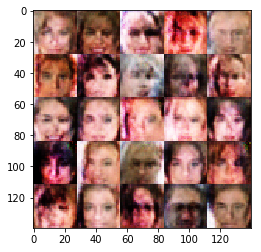

Epochs 1,batches 1210, dis_loss 1.4150786399841309 , gen_loss 0.616083025932312
Epochs 1,batches 1220, dis_loss 1.3932446241378784 , gen_loss 0.8925445079803467
Epochs 1,batches 1230, dis_loss 1.309631586074829 , gen_loss 0.817650318145752
Epochs 1,batches 1240, dis_loss 1.397867202758789 , gen_loss 0.6770484447479248
Epochs 1,batches 1250, dis_loss 1.3867943286895752 , gen_loss 0.8676505088806152
Epochs 1,batches 1260, dis_loss 1.5410795211791992 , gen_loss 0.5091909170150757
Epochs 1,batches 1270, dis_loss 1.4887497425079346 , gen_loss 0.666663408279419
Epochs 1,batches 1280, dis_loss 1.39152991771698 , gen_loss 0.6935396194458008
Epochs 1,batches 1290, dis_loss 1.3961749076843262 , gen_loss 0.8788728713989258
Epochs 1,batches 1300, dis_loss 1.4137394428253174 , gen_loss 0.9090434312820435


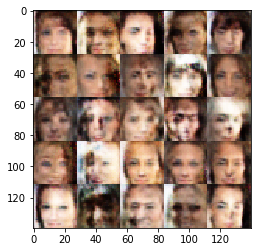

Epochs 1,batches 1310, dis_loss 1.4118852615356445 , gen_loss 0.810348629951477
Epochs 1,batches 1320, dis_loss 1.3530330657958984 , gen_loss 0.7874481678009033
Epochs 1,batches 1330, dis_loss 1.4796967506408691 , gen_loss 0.6364150047302246
Epochs 1,batches 1340, dis_loss 1.3719627857208252 , gen_loss 0.8307326436042786
Epochs 1,batches 1350, dis_loss 1.4351526498794556 , gen_loss 0.6421804428100586
Epochs 1,batches 1360, dis_loss 1.3377904891967773 , gen_loss 0.8144032955169678
Epochs 1,batches 1370, dis_loss 1.3731142282485962 , gen_loss 0.6756861805915833
Epochs 1,batches 1380, dis_loss 1.390394687652588 , gen_loss 0.6770226359367371
Epochs 1,batches 1390, dis_loss 1.3757519721984863 , gen_loss 0.8929804563522339
Epochs 1,batches 1400, dis_loss 1.4244049787521362 , gen_loss 0.9232890605926514


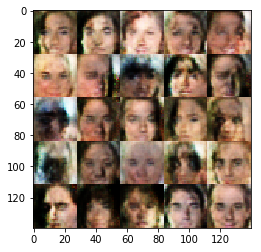

Epochs 1,batches 1410, dis_loss 1.4377436637878418 , gen_loss 0.9043266773223877
Epochs 1,batches 1420, dis_loss 1.4960386753082275 , gen_loss 0.7646033763885498
Epochs 1,batches 1430, dis_loss 1.4033883810043335 , gen_loss 0.6349467039108276
Epochs 1,batches 1440, dis_loss 1.401323914527893 , gen_loss 0.6426183581352234
Epochs 1,batches 1450, dis_loss 1.3816807270050049 , gen_loss 0.7728246450424194
Epochs 1,batches 1460, dis_loss 1.3701255321502686 , gen_loss 0.9784985780715942
Epochs 1,batches 1470, dis_loss 1.362156867980957 , gen_loss 0.7885684967041016
Epochs 1,batches 1480, dis_loss 1.4039826393127441 , gen_loss 0.6655938625335693
Epochs 1,batches 1490, dis_loss 1.4054230451583862 , gen_loss 0.6931113004684448
Epochs 1,batches 1500, dis_loss 1.4273884296417236 , gen_loss 0.6788852214813232


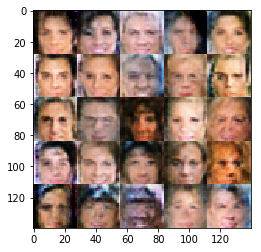

Epochs 1,batches 1510, dis_loss 1.3984675407409668 , gen_loss 0.8010638952255249
Epochs 1,batches 1520, dis_loss 1.4000104665756226 , gen_loss 0.7893285751342773
Epochs 1,batches 1530, dis_loss 1.4161211252212524 , gen_loss 0.8133174180984497
Epochs 1,batches 1540, dis_loss 1.4823720455169678 , gen_loss 0.7134428024291992
Epochs 1,batches 1550, dis_loss 1.3514190912246704 , gen_loss 0.6872255802154541
Epochs 1,batches 1560, dis_loss 1.329613447189331 , gen_loss 0.9357800483703613
Epochs 1,batches 1570, dis_loss 1.4458873271942139 , gen_loss 0.6305230259895325
Epochs 1,batches 1580, dis_loss 1.3463141918182373 , gen_loss 0.7981031537055969
Epochs 1,batches 1590, dis_loss 1.4269331693649292 , gen_loss 0.8432563543319702
Epochs 1,batches 1600, dis_loss 1.393442153930664 , gen_loss 0.753514289855957


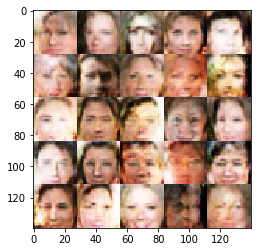

Epochs 1,batches 1610, dis_loss 1.4970115423202515 , gen_loss 0.5338642001152039
Epochs 1,batches 1620, dis_loss 1.3671915531158447 , gen_loss 0.8964729309082031
Epochs 1,batches 1630, dis_loss 1.3430675268173218 , gen_loss 0.7693763971328735
Epochs 1,batches 1640, dis_loss 1.417778730392456 , gen_loss 0.7935632467269897
Epochs 1,batches 1650, dis_loss 1.4024152755737305 , gen_loss 0.6463538408279419
Epochs 1,batches 1660, dis_loss 1.3778306245803833 , gen_loss 0.7741532921791077
Epochs 1,batches 1670, dis_loss 1.380746841430664 , gen_loss 0.7011182308197021
Epochs 1,batches 1680, dis_loss 1.569622278213501 , gen_loss 1.08162522315979
Epochs 1,batches 1690, dis_loss 1.421349287033081 , gen_loss 0.7098397016525269
Epochs 1,batches 1700, dis_loss 1.3428747653961182 , gen_loss 0.7541277408599854


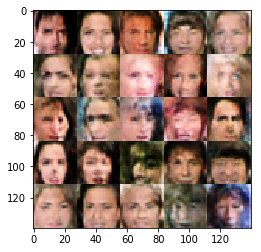

Epochs 1,batches 1710, dis_loss 1.3771989345550537 , gen_loss 0.7570483684539795
Epochs 1,batches 1720, dis_loss 1.3936545848846436 , gen_loss 0.8134183883666992
Epochs 1,batches 1730, dis_loss 1.40566086769104 , gen_loss 0.8804433345794678
Epochs 1,batches 1740, dis_loss 1.4002351760864258 , gen_loss 0.859388530254364
Epochs 1,batches 1750, dis_loss 1.4162521362304688 , gen_loss 0.7492514848709106
Epochs 1,batches 1760, dis_loss 1.3875112533569336 , gen_loss 0.8217352628707886
Epochs 1,batches 1770, dis_loss 1.3564609289169312 , gen_loss 0.7481551766395569
Epochs 1,batches 1780, dis_loss 1.4204967021942139 , gen_loss 0.681215763092041
Epochs 1,batches 1790, dis_loss 1.3961296081542969 , gen_loss 0.6792408227920532
Epochs 1,batches 1800, dis_loss 1.407545804977417 , gen_loss 0.6818722486495972


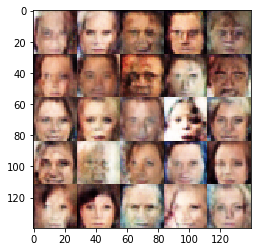

Epochs 1,batches 1810, dis_loss 1.423181414604187 , gen_loss 0.7307767271995544
Epochs 1,batches 1820, dis_loss 1.425746202468872 , gen_loss 0.6858468055725098
Epochs 1,batches 1830, dis_loss 1.3724305629730225 , gen_loss 0.7971059083938599
Epochs 1,batches 1840, dis_loss 1.4026482105255127 , gen_loss 0.9864537119865417
Epochs 1,batches 1850, dis_loss 1.319218635559082 , gen_loss 0.9559639692306519
Epochs 1,batches 1860, dis_loss 1.5305964946746826 , gen_loss 0.4849545955657959
Epochs 1,batches 1870, dis_loss 1.4000144004821777 , gen_loss 0.647503137588501
Epochs 1,batches 1880, dis_loss 1.3163982629776 , gen_loss 0.7812818884849548
Epochs 1,batches 1890, dis_loss 1.3782281875610352 , gen_loss 0.7219411730766296
Epochs 1,batches 1900, dis_loss 1.3949790000915527 , gen_loss 0.6960426568984985


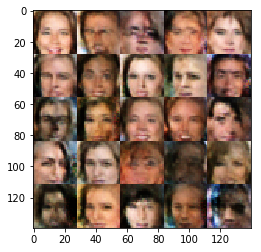

Epochs 1,batches 1910, dis_loss 1.3993741273880005 , gen_loss 0.6842368245124817
Epochs 1,batches 1920, dis_loss 1.3262231349945068 , gen_loss 0.8204600214958191
Epochs 1,batches 1930, dis_loss 1.391896367073059 , gen_loss 0.6143532991409302
Epochs 1,batches 1940, dis_loss 1.3264480829238892 , gen_loss 0.7370092868804932
Epochs 1,batches 1950, dis_loss 1.4592677354812622 , gen_loss 0.9957368969917297
Epochs 1,batches 1960, dis_loss 1.3709735870361328 , gen_loss 0.7740738391876221
Epochs 1,batches 1970, dis_loss 1.337894082069397 , gen_loss 0.7061112523078918
Epochs 1,batches 1980, dis_loss 1.3989992141723633 , gen_loss 0.7338100075721741
Epochs 1,batches 1990, dis_loss 1.3627188205718994 , gen_loss 0.8217950463294983
Epochs 1,batches 2000, dis_loss 1.3735566139221191 , gen_loss 0.9006242156028748


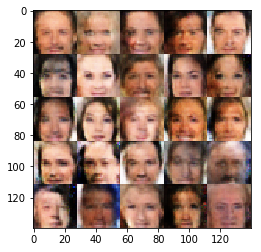

Epochs 1,batches 2010, dis_loss 1.4283294677734375 , gen_loss 0.8077197074890137
Epochs 1,batches 2020, dis_loss 1.4756190776824951 , gen_loss 0.6773747801780701
Epochs 1,batches 2030, dis_loss 1.3485028743743896 , gen_loss 0.7957782745361328
Epochs 1,batches 2040, dis_loss 1.4388538599014282 , gen_loss 0.7142931222915649
Epochs 1,batches 2050, dis_loss 1.4045019149780273 , gen_loss 0.7415642738342285
Epochs 1,batches 2060, dis_loss 1.358446478843689 , gen_loss 0.6455312967300415
Epochs 1,batches 2070, dis_loss 1.4002606868743896 , gen_loss 0.661278486251831
Epochs 1,batches 2080, dis_loss 1.3946303129196167 , gen_loss 0.9041945934295654
Epochs 1,batches 2090, dis_loss 1.4783294200897217 , gen_loss 0.9921631813049316
Epochs 1,batches 2100, dis_loss 1.4070987701416016 , gen_loss 0.7051067352294922


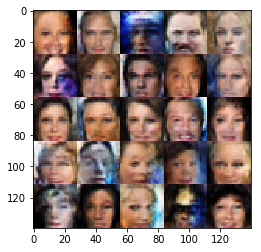

Epochs 1,batches 2110, dis_loss 1.3570137023925781 , gen_loss 0.8066918253898621
Epochs 1,batches 2120, dis_loss 1.352811574935913 , gen_loss 0.7720515727996826
Epochs 1,batches 2130, dis_loss 1.4646075963974 , gen_loss 0.6918560266494751
Epochs 1,batches 2140, dis_loss 1.494844675064087 , gen_loss 0.851251482963562
Epochs 1,batches 2150, dis_loss 1.3668584823608398 , gen_loss 0.8827979564666748
Epochs 1,batches 2160, dis_loss 1.4093425273895264 , gen_loss 0.7636740207672119
Epochs 1,batches 2170, dis_loss 1.3497426509857178 , gen_loss 0.9129305481910706
Epochs 1,batches 2180, dis_loss 1.371556282043457 , gen_loss 0.8332511186599731
Epochs 1,batches 2190, dis_loss 1.420515775680542 , gen_loss 0.608506441116333
Epochs 1,batches 2200, dis_loss 1.3059375286102295 , gen_loss 0.8898186683654785


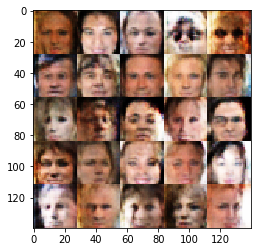

Epochs 1,batches 2210, dis_loss 1.4322850704193115 , gen_loss 0.8383733034133911
Epochs 1,batches 2220, dis_loss 1.3350579738616943 , gen_loss 0.8404282331466675
Epochs 1,batches 2230, dis_loss 1.3663314580917358 , gen_loss 0.8606281280517578
Epochs 1,batches 2240, dis_loss 1.401764988899231 , gen_loss 0.7596752643585205
Epochs 1,batches 2250, dis_loss 1.4804353713989258 , gen_loss 0.8520200848579407
Epochs 1,batches 2260, dis_loss 1.4703447818756104 , gen_loss 0.5228691101074219
Epochs 1,batches 2270, dis_loss 1.365756869316101 , gen_loss 0.7103636860847473
Epochs 1,batches 2280, dis_loss 1.3408030271530151 , gen_loss 0.9064590930938721
Epochs 1,batches 2290, dis_loss 1.3990501165390015 , gen_loss 0.84458327293396
Epochs 1,batches 2300, dis_loss 1.402001142501831 , gen_loss 0.8278100490570068


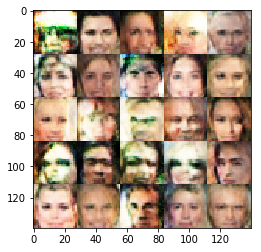

Epochs 1,batches 2310, dis_loss 1.3621208667755127 , gen_loss 0.7812096476554871
Epochs 1,batches 2320, dis_loss 1.4143542051315308 , gen_loss 0.7754138708114624
Epochs 1,batches 2330, dis_loss 1.3613321781158447 , gen_loss 0.7401837110519409
Epochs 1,batches 2340, dis_loss 1.4287021160125732 , gen_loss 0.5716254711151123
Epochs 1,batches 2350, dis_loss 1.3716564178466797 , gen_loss 0.8014960289001465
Epochs 1,batches 2360, dis_loss 1.3429386615753174 , gen_loss 0.7235286235809326
Epochs 1,batches 2370, dis_loss 1.3893165588378906 , gen_loss 0.8615908622741699
Epochs 1,batches 2380, dis_loss 1.3548760414123535 , gen_loss 0.7456904649734497
Epochs 1,batches 2390, dis_loss 1.3963344097137451 , gen_loss 0.6176890134811401
Epochs 1,batches 2400, dis_loss 1.431288719177246 , gen_loss 0.776425838470459


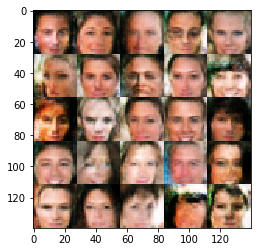

Epochs 1,batches 2410, dis_loss 1.3573685884475708 , gen_loss 0.8206484913825989
Epochs 1,batches 2420, dis_loss 1.3963069915771484 , gen_loss 0.758952260017395
Epochs 1,batches 2430, dis_loss 1.3385543823242188 , gen_loss 0.9876518249511719
Epochs 1,batches 2440, dis_loss 1.384192705154419 , gen_loss 0.7897108197212219
Epochs 1,batches 2450, dis_loss 1.3892638683319092 , gen_loss 0.772419810295105
Epochs 1,batches 2460, dis_loss 1.3713493347167969 , gen_loss 0.7069854736328125
Epochs 1,batches 2470, dis_loss 1.4066206216812134 , gen_loss 0.6339969635009766
Epochs 1,batches 2480, dis_loss 1.375964879989624 , gen_loss 0.8281692266464233
Epochs 1,batches 2490, dis_loss 1.4300150871276855 , gen_loss 0.7863380908966064
Epochs 1,batches 2500, dis_loss 1.3497614860534668 , gen_loss 0.9460208415985107


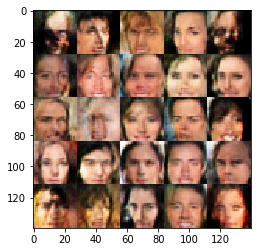

Epochs 1,batches 2510, dis_loss 1.4257980585098267 , gen_loss 0.6775461435317993
Epochs 1,batches 2520, dis_loss 1.3697288036346436 , gen_loss 0.8407687544822693
Epochs 1,batches 2530, dis_loss 1.3659403324127197 , gen_loss 0.8282179236412048
Epochs 1,batches 2540, dis_loss 1.412057638168335 , gen_loss 0.6012998819351196
Epochs 1,batches 2550, dis_loss 1.4454063177108765 , gen_loss 0.5960712432861328
Epochs 1,batches 2560, dis_loss 1.4194247722625732 , gen_loss 0.8696542382240295
Epochs 1,batches 2570, dis_loss 1.3587626218795776 , gen_loss 0.8050652742385864
Epochs 1,batches 2580, dis_loss 1.3869712352752686 , gen_loss 0.7343491911888123
Epochs 1,batches 2590, dis_loss 1.410649061203003 , gen_loss 0.5539287328720093
Epochs 1,batches 2600, dis_loss 1.3572173118591309 , gen_loss 0.724465012550354


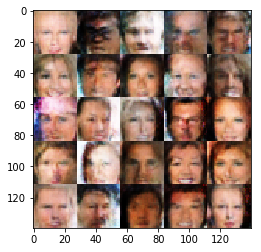

Epochs 1,batches 2610, dis_loss 1.3687565326690674 , gen_loss 0.6193379163742065
Epochs 1,batches 2620, dis_loss 1.402693748474121 , gen_loss 0.797562301158905
Epochs 1,batches 2630, dis_loss 1.3940818309783936 , gen_loss 0.6044508814811707
Epochs 1,batches 2640, dis_loss 1.3838720321655273 , gen_loss 0.8665825724601746
Epochs 1,batches 2650, dis_loss 1.385450005531311 , gen_loss 0.6798889636993408
Epochs 1,batches 2660, dis_loss 1.4030907154083252 , gen_loss 1.0478111505508423
Epochs 1,batches 2670, dis_loss 1.3833037614822388 , gen_loss 0.8995159268379211
Epochs 1,batches 2680, dis_loss 1.4302072525024414 , gen_loss 1.0827723741531372
Epochs 1,batches 2690, dis_loss 1.420541524887085 , gen_loss 0.6545388102531433
Epochs 1,batches 2700, dis_loss 1.3689329624176025 , gen_loss 0.6819295883178711


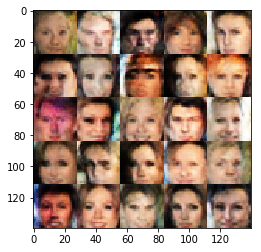

Epochs 1,batches 2710, dis_loss 1.3296356201171875 , gen_loss 0.7171462774276733
Epochs 1,batches 2720, dis_loss 1.409751296043396 , gen_loss 0.6935504674911499
Epochs 1,batches 2730, dis_loss 1.3751025199890137 , gen_loss 0.7294256687164307
Epochs 1,batches 2740, dis_loss 1.3515563011169434 , gen_loss 0.858680009841919
Epochs 1,batches 2750, dis_loss 1.3414130210876465 , gen_loss 0.7935472130775452
Epochs 1,batches 2760, dis_loss 1.4184123277664185 , gen_loss 0.9157870411872864
Epochs 1,batches 2770, dis_loss 1.3967039585113525 , gen_loss 0.6103681921958923
Epochs 1,batches 2780, dis_loss 1.4378749132156372 , gen_loss 0.6115930080413818
Epochs 1,batches 2790, dis_loss 1.3679442405700684 , gen_loss 0.7579060196876526
Epochs 1,batches 2800, dis_loss 1.3263418674468994 , gen_loss 0.7666504383087158


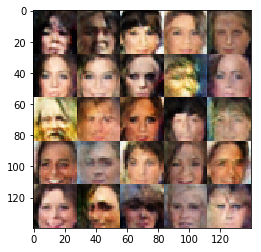

Epochs 1,batches 2810, dis_loss 1.4197192192077637 , gen_loss 0.756271481513977
Epochs 1,batches 2820, dis_loss 1.3781758546829224 , gen_loss 0.6593124270439148
Epochs 1,batches 2830, dis_loss 1.3262741565704346 , gen_loss 0.9052845239639282
Epochs 1,batches 2840, dis_loss 1.3367176055908203 , gen_loss 0.9128297567367554
Epochs 1,batches 2850, dis_loss 1.3963357210159302 , gen_loss 0.6473531126976013
Epochs 1,batches 2860, dis_loss 1.3505558967590332 , gen_loss 0.7950501441955566
Epochs 1,batches 2870, dis_loss 1.3364564180374146 , gen_loss 0.8427850008010864
Epochs 1,batches 2880, dis_loss 1.3078536987304688 , gen_loss 0.8114992380142212
Epochs 1,batches 2890, dis_loss 1.3798837661743164 , gen_loss 0.712051510810852
Epochs 1,batches 2900, dis_loss 1.3942707777023315 , gen_loss 0.9464728236198425


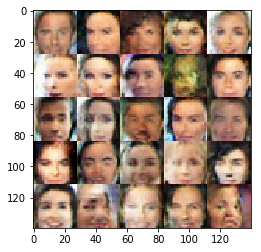

Epochs 1,batches 2910, dis_loss 1.4200952053070068 , gen_loss 0.59998619556427
Epochs 1,batches 2920, dis_loss 1.3746929168701172 , gen_loss 0.9232286214828491
Epochs 1,batches 2930, dis_loss 1.3028194904327393 , gen_loss 0.7656790018081665
Epochs 1,batches 2940, dis_loss 1.4343328475952148 , gen_loss 0.5967490673065186
Epochs 1,batches 2950, dis_loss 1.3350833654403687 , gen_loss 0.7796895503997803
Epochs 1,batches 2960, dis_loss 1.3604316711425781 , gen_loss 0.8674733638763428
Epochs 1,batches 2970, dis_loss 1.3608818054199219 , gen_loss 0.7400363683700562
Epochs 1,batches 2980, dis_loss 1.408717393875122 , gen_loss 0.8021426200866699
Epochs 1,batches 2990, dis_loss 1.3631532192230225 , gen_loss 0.9696700572967529
Epochs 1,batches 3000, dis_loss 1.3907301425933838 , gen_loss 0.646931529045105


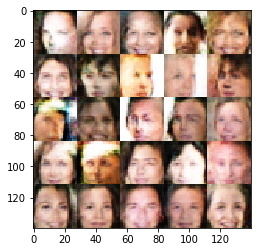

Epochs 1,batches 3010, dis_loss 1.3799457550048828 , gen_loss 1.055673599243164
Epochs 1,batches 3020, dis_loss 1.3989613056182861 , gen_loss 0.662492036819458
Epochs 1,batches 3030, dis_loss 1.3843562602996826 , gen_loss 0.7537504434585571
Epochs 1,batches 3040, dis_loss 1.3972185850143433 , gen_loss 0.7034681439399719
Epochs 1,batches 3050, dis_loss 1.339128851890564 , gen_loss 0.7499780654907227
Epochs 1,batches 3060, dis_loss 1.3652631044387817 , gen_loss 0.9505706429481506
Epochs 1,batches 3070, dis_loss 1.380828619003296 , gen_loss 0.7918006181716919
Epochs 1,batches 3080, dis_loss 1.3767645359039307 , gen_loss 0.7044974565505981
Epochs 1,batches 3090, dis_loss 1.3978716135025024 , gen_loss 0.7145182490348816
Epochs 1,batches 3100, dis_loss 1.4109007120132446 , gen_loss 0.8298968076705933


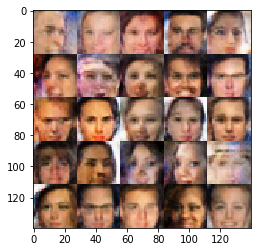

Epochs 1,batches 3110, dis_loss 1.4410794973373413 , gen_loss 0.634198784828186
Epochs 1,batches 3120, dis_loss 1.3634607791900635 , gen_loss 0.7514418363571167
Epochs 1,batches 3130, dis_loss 1.3739349842071533 , gen_loss 0.7390242218971252
Epochs 1,batches 3140, dis_loss 1.3443894386291504 , gen_loss 0.7268059253692627
Epochs 1,batches 3150, dis_loss 1.4375172853469849 , gen_loss 0.582127034664154
Epochs 1,batches 3160, dis_loss 1.3692255020141602 , gen_loss 0.6528512835502625


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.